### Process daily UNSEEN ###

Processes the model data for a given initialisation year (e.g. s1960), ensemble member (e.g. r1i1p1f2), model (e.g. HadGEM3-GC31-MM), spatial area (e.g. UK) and variable (e.g. tas) into a dataframe.

In [1]:
# Local imports
import os
import sys
import time
import argparse

# Third-party imports
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import shapely.geometry
import cartopy.io.shapereader as shpreader
import iris

# Specific imports
from tqdm import tqdm
from datetime import datetime, timedelta

/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


In [2]:
# Load my specific functions
sys.path.append("/home/users/benhutch/unseen_functions")
import functions as funcs

In [3]:
# Hard coded args
model = "HadGEM3-GC31-MM"
experiment = "dcppA-hindcast"
freq = "day"
months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

# Set up the output directory for the dfs
output_dir_dfs = "/gws/nopw/j04/canari/users/benhutch/unseen/saved_dfs"

In [4]:
# Flexible args
variable = "tas"
country = "United Kingdom"
init_year = 1960

In [5]:
# HadGEM3-GC31-MM_dcppA-hindcast_tas_United_Kingdom_1960-2018_day.csv
# ERA5_tas_United_Kingdom_1960-2018_daily.csv

# load the model data
df_model_tas = pd.read_csv(f"{output_dir_dfs}/HadGEM3-GC31-MM_dcppA-hindcast_tas_United_Kingdom_1960-2018_day.csv")
df_model_sfcWind = pd.read_csv(f"{output_dir_dfs}/HadGEM3-GC31-MM_dcppA-hindcast_sfcWind_United_Kingdom_1960-2018_day.csv")

# set up the directory to non-regridded ERA5 data for UK SOTCES
# sotces_path = "/home/users/benhutch/energy-sotcr-2023/data/ERA5_UK_1940_2024_daily_SP_WP_demand_wind.csv"

# # cheat with the clearheads data for 10m wind speed uk
ch_wind_speed = "/home/users/benhutch/unseen_multi_year/dfs/UK_clearheads_data_daily_1950_2020_ONDJFM.csv"

# test_obs = "/gws/nopw/j04/canari/users/benhutch/unseen/saved_dfs/ERA5_tas_United_Kingdom_1960-2018_daily_2024-11-26.csv"

# Load the observed data
df_obs = pd.read_csv(ch_wind_speed)

# # Set the df_obs to the clearheads data
# df_obs = pd.read_csv(test_obs)

In [6]:
# head of df_model_tas
print(df_model_tas.head())

   init_year  member  lead        data
0       1960       1     1  283.904326
1       1960       1     2  281.653069
2       1960       1     3  280.558694
3       1960       1     4  280.931852
4       1960       1     5  280.171699


In [7]:
# print the mean of the data column in df_model_tas
print(np.mean(df_model_tas["data"]))

281.1897112834186


In [8]:
df_obs.head()

,Unnamed: 0,solar_power,100m_wind_speed,10m_wind_speed,solar_irradiance,ofs_cfs,ons_cfs,t2m_no_detrend,t2m_2020_detrend,United_Kingdom_demand,United_Kingdom_wd_demand
0,1950-01-01,0.017917,8.046321,5.313242,18.246765,0.375553,0.378995,5.568366,7.035546,38.408018,43.098834
1,1950-01-02,0.009749,8.309860,5.536100,10.066186,0.755816,0.260311,7.458939,8.926063,40.257548,41.065818
2,1950-01-03,0.006689,5.999976,3.996584,6.909895,0.383306,0.247291,6.999079,8.466145,41.153278,41.153278
3,1950-01-04,0.014198,7.579509,4.991658,14.658528,0.503725,0.366872,7.507976,8.974984,40.990399,40.990399
4,1950-01-05,0.009825,9.282607,6.286204,10.173406,0.768395,0.415419,6.869317,8.336267,41.490605,41.490605


In [9]:
# # print the mean of the data column in df_obs
# print(np.mean(df_obs["data"]))

In [10]:
# import matplotlib.pyplot as plt

# # Plot the normalized frequency distribution of the data column in df_model_tas
# plt.hist(df_model_tas["data"], bins=100, density=True, alpha=0.5, label='Model Data')

# # Plot the normalized frequency distribution of the data column in df_obs
# plt.hist(df_obs["data"], bins=100, density=True, alpha=0.5, label='Observed Data')

# # Add labels and legend
# plt.xlabel('Data')
# plt.ylabel('Normalized Frequency')
# plt.legend()

# # Show the plot
# plt.show()

In [11]:
# head of df_model_sfcWind
print(df_model_sfcWind.head())

   init_year  member  lead      data
0       1960       1     1  8.429288
1       1960       1     2  9.267500
2       1960       1     3  7.539931
3       1960       1     4  7.504783
4       1960       1     5  5.574239


In [12]:
# rename the data column in df_model_tas to UK_tas
df_model_tas.rename(columns={"data": "UK_tas"}, inplace=True)

# rename the data column in df_model_sfcWind to UK_sfcWind
df_model_sfcWind.rename(columns={"data": "UK_sfcWind"}, inplace=True)

In [13]:
# join the two dataframes
df_model = df_model_tas.merge(df_model_sfcWind, on=("init_year", "member", "lead"))

In [14]:
# convert UK_tas to degrees C
df_model["UK_tas"] = df_model["UK_tas"] - 273.15

In [15]:
df_model.tail()

,init_year,member,lead,UK_tas,UK_sfcWind
2212505,2018,10,3746,4.651051,7.075536
2212506,2018,10,3747,3.291295,3.919252
2212507,2018,10,3748,4.368680,3.330906
2212508,2018,10,3749,5.886363,5.101384
2212509,2018,10,3750,8.690242,5.210266


In [16]:
# subset the model to the correct years
winter_years = np.arange(1, 10 + 1)

# set up a new df to append to
df_model_ondjfm= pd.DataFrame()

# Loop over the winter years
for i, wyear in enumerate(winter_years):
    # Set up the leads to extract
    leads = np.arange(331 + (i * 360), 331 + 180 + (i * 360))

    # Extract the data
    df_model_leads_this = df_model[df_model["lead"].isin(leads)]

    # include a new column

    # Append to the new df
    df_model_ondjfm = pd.concat([df_model_ondjfm, df_model_leads_this])
    

In [17]:
df_model_ondjfm.shape

(1062000, 5)

In [18]:
df_obs.head()

,Unnamed: 0,solar_power,100m_wind_speed,10m_wind_speed,solar_irradiance,ofs_cfs,ons_cfs,t2m_no_detrend,t2m_2020_detrend,United_Kingdom_demand,United_Kingdom_wd_demand
0,1950-01-01,0.017917,8.046321,5.313242,18.246765,0.375553,0.378995,5.568366,7.035546,38.408018,43.098834
1,1950-01-02,0.009749,8.309860,5.536100,10.066186,0.755816,0.260311,7.458939,8.926063,40.257548,41.065818
2,1950-01-03,0.006689,5.999976,3.996584,6.909895,0.383306,0.247291,6.999079,8.466145,41.153278,41.153278
3,1950-01-04,0.014198,7.579509,4.991658,14.658528,0.503725,0.366872,7.507976,8.974984,40.990399,40.990399
4,1950-01-05,0.009825,9.282607,6.286204,10.173406,0.768395,0.415419,6.869317,8.336267,41.490605,41.490605


In [19]:
# formatthe date as a datetime
df_obs["Unnamed: 0"] = pd.to_datetime(df_obs["Unnamed: 0"])

In [20]:
# rename unnamed to date
df_obs.rename(columns={"Unnamed: 0": "date"}, inplace=True)

In [21]:
# set the date as the index
df_obs.set_index("date", inplace=True)

In [22]:
df_obs.head()

,solar_power,100m_wind_speed,10m_wind_speed,solar_irradiance,ofs_cfs,ons_cfs,t2m_no_detrend,t2m_2020_detrend,United_Kingdom_demand,United_Kingdom_wd_demand
date,,,,,,,,,,
1950-01-01,0.017917,8.046321,5.313242,18.246765,0.375553,0.378995,5.568366,7.035546,38.408018,43.098834
1950-01-02,0.009749,8.309860,5.536100,10.066186,0.755816,0.260311,7.458939,8.926063,40.257548,41.065818
1950-01-03,0.006689,5.999976,3.996584,6.909895,0.383306,0.247291,6.999079,8.466145,41.153278,41.153278
1950-01-04,0.014198,7.579509,4.991658,14.658528,0.503725,0.366872,7.507976,8.974984,40.990399,40.990399
1950-01-05,0.009825,9.282607,6.286204,10.173406,0.768395,0.415419,6.869317,8.336267,41.490605,41.490605


In [23]:
# Make some assumptions about the power system
# wind power capacity factors - includes both onshore and offshore?
# also I guess power system is 2021 ish set up?
# although won't have changed significantly since then
# Not sure how accurate these are leached from:
# https://windeurope.org/intelligence-platform/product/wind-energy-in-europe-2023-statistics-and-the-outlook-for-2024-2030/
installed_ofs_2023 = 14.756  # GW
installed_ons_2023 = 14.866  # GW

# set up these but for France
installed_ofs_2023_fr = 0.842  # GW
installed_ons_2023_fr = 21.935  # GW

# calculate the wind power generation
df_obs["wind_gen"] = (
    installed_ofs_2023 * df_obs["ofs_cfs"]
    + installed_ons_2023 * df_obs["ons_cfs"]
)

# calculate the demand net wind
df_obs["demand_net_wind"] = (
    df_obs["United_Kingdom_demand"] - df_obs["wind_gen"]
)

# calculate the weather dependent demand
df_obs["wd_demand_net_wind"] = (
    df_obs["United_Kingdom_wd_demand"] - df_obs["wind_gen"]
)

In [24]:
# Subset df_obs to 1960 to 2018
df_obs_constraint = df_obs.loc[(df_obs.index.year >= 1960) & (df_obs.index.year <= 2018)]

In [25]:
# Subset to the months of interest [10, 11, 12, 1, 2, 3]
df_obs_constraint = df_obs_constraint.loc[df_obs_constraint.index.month.isin([10, 11, 12, 1, 2, 3])]

In [26]:
df_obs_constraint.head()

,solar_power,100m_wind_speed,10m_wind_speed,solar_irradiance,ofs_cfs,ons_cfs,t2m_no_detrend,t2m_2020_detrend,United_Kingdom_demand,United_Kingdom_wd_demand,wind_gen,demand_net_wind,wd_demand_net_wind
date,,,,,,,,,,,,,
1960-01-01,0.017302,7.625868,5.137020,47.696808,0.766016,0.298726,6.577980,7.835584,40.766836,41.666578,15.744187,25.022648,25.922391
1960-01-02,0.016300,4.930154,3.186221,44.535210,0.161353,0.101100,3.956466,5.214012,40.019199,43.863111,3.883881,36.135318,39.979230
1960-01-03,0.014511,7.249626,4.753627,39.765705,0.298246,0.266276,5.730921,6.988410,37.949476,42.640292,8.359369,29.590107,34.280923
1960-01-04,0.016632,9.558028,6.228839,46.044937,0.526643,0.363619,7.894082,9.151514,39.775870,40.584140,13.176714,26.599156,27.407426
1960-01-05,0.026247,8.874397,6.005377,71.949350,0.798906,0.376032,5.362875,6.620249,42.761398,42.761398,17.378747,25.382651,25.382651


In [27]:
# save this file
df_obs_constraint.to_csv("/home/users/benhutch/unseen_multi_year/dfs/UK_clearheads_data_daily_1960_2018_ONDJFM.csv")

In [28]:
df_model_ondjfm.head()

,init_year,member,lead,UK_tas,UK_sfcWind
330,1960,1,331,10.194633,4.469876
331,1960,1,332,11.097110,5.489894
332,1960,1,333,11.798156,6.172364
333,1960,1,334,11.379038,4.134217
334,1960,1,335,11.771268,4.603901


In [29]:
# reset index for the obs
df_obs_constraint.reset_index(inplace=True)

In [30]:
df_obs_constraint.head()

,date,solar_power,100m_wind_speed,10m_wind_speed,solar_irradiance,ofs_cfs,ons_cfs,t2m_no_detrend,t2m_2020_detrend,United_Kingdom_demand,United_Kingdom_wd_demand,wind_gen,demand_net_wind,wd_demand_net_wind
0,1960-01-01,0.017302,7.625868,5.137020,47.696808,0.766016,0.298726,6.577980,7.835584,40.766836,41.666578,15.744187,25.022648,25.922391
1,1960-01-02,0.016300,4.930154,3.186221,44.535210,0.161353,0.101100,3.956466,5.214012,40.019199,43.863111,3.883881,36.135318,39.979230
2,1960-01-03,0.014511,7.249626,4.753627,39.765705,0.298246,0.266276,5.730921,6.988410,37.949476,42.640292,8.359369,29.590107,34.280923
3,1960-01-04,0.016632,9.558028,6.228839,46.044937,0.526643,0.363619,7.894082,9.151514,39.775870,40.584140,13.176714,26.599156,27.407426
4,1960-01-05,0.026247,8.874397,6.005377,71.949350,0.798906,0.376032,5.362875,6.620249,42.761398,42.761398,17.378747,25.382651,25.382651


In [31]:
import random
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr, norm, ks_2samp
from sklearn.metrics import r2_score, mean_squared_error

# Set up the variables for using the function
obs_time_name = "date"
block_length = 10
nboot = 1000 # for testing purposes
num_trials = 1000
X1_col_obs = "10m_wind_speed"
X2_col_obs = "t2m_no_detrend"
Y_col = "wd_demand_net_wind"
X1_col_model = "UK_sfcWind"
X2_col_model = "UK_tas"

# set up the model time name
model_time_name = "init_year"
model_member_name = "member"
model_lead_name = "lead"

In [32]:
df_model_ondjfm.head()

,init_year,member,lead,UK_tas,UK_sfcWind
330,1960,1,331,10.194633,4.469876
331,1960,1,332,11.097110,5.489894
332,1960,1,333,11.798156,6.172364
333,1960,1,334,11.379038,4.134217
334,1960,1,335,11.771268,4.603901


In [33]:
# reset the index of df_model_ondjfm
df_model_ondjfm.reset_index(inplace=True)

In [34]:
# set up the tests dataset
# limit df_model_ondjfm to 1000 rows
df_model_ondjfm_test = df_model_ondjfm.loc[0:1000]

In [35]:
%%time

# Sample the uncertainty in the linear fit
# and due to the limited sample size of the obs
ntimes = len(df_obs_constraint[obs_time_name].unique())

# Get the number of blocks
nblocks = int(ntimes / block_length)

# if the nblocks * block is less than the ntimes
if (nblocks * block_length) < ntimes:
    # add one to the nblocks
    nblocks = nblocks + 1

# set up the index for time
index_time = range(ntimes - block_length + 1)

# set up the empty array for the bootstrapped data
X1_boot_full = np.zeros((nboot, ntimes))
X2_boot_full = np.zeros((nboot, ntimes))
Y_boot_full = np.zeros((nboot, ntimes))

# Set up an empty array for the residuals
residuals_boot = np.zeros((nboot, ntimes))

# Set up an empty array for the spread
res_spread_boot = np.zeros(nboot)

# set up an empty array for the r2 and rmse values
r2_boot = np.zeros(nboot)
rmse_boot = np.zeros(nboot)

# loop over the nboot
for iboot in tqdm(np.arange(nboot)):
    # Select starting indices for the blocks
    if iboot == 0:
        ind_time_this = range(0, ntimes, block_length)
    else:  # random samples
        ind_time_this = np.array(
            [random.choice(index_time) for _ in range(nblocks)]
        )

    # Set up the shape of the bootstrapped data
    X1_boot = np.zeros(ntimes)
    X2_boot = np.zeros(ntimes)

    # Same for the predictand
    Y_boot = np.zeros(ntimes)

    # reset time index
    itime = 0

    # loop over the indices
    for ithis in ind_time_this:
        # Set up the block index
        ind_block = np.arange(ithis, ithis + block_length)

        # if the block index is greater than the number of times
        # then subtract the number of times from the block index
        ind_block[(ind_block > ntimes - 1)] = (
            ind_block[(ind_block > ntimes - 1)] - ntimes
        )

        # Restrict the block index to the minimum of the block length
        ind_block = ind_block[: min(block_length, ntimes - itime)]

        # loop over the blocks
        for iblock in ind_block:
            # Set up the bootstrapped data
            X1_boot[itime] = df_obs_constraint[X1_col_obs].values[iblock]
            X2_boot[itime] = df_obs_constraint[X2_col_obs].values[iblock]
            Y_boot[itime] = df_obs_constraint[Y_col].values[iblock]

            # increment the time index
            itime += 1

    # Append the data
    X1_boot_full[iboot, :] = X1_boot
    X2_boot_full[iboot, :] = X2_boot
    Y_boot_full[iboot, :] = Y_boot

    if iboot == 0:
        ind_time_this = range(0, ntimes, block_length)

        X_boot_first = np.column_stack((X1_boot, X2_boot))

        # Fit the model
        model_first = LinearRegression().fit(X_boot_first, Y_boot)

        # predict the values of Y
        Y_pred_first = model_first.predict(X_boot_first)

        # calculate and append the r2 and rmse values
        r2_boot_first = model_first.score(X_boot_first, Y_boot)

        # Calculate the residuals
        # the difference between the actual and predicted values
        residuals_boot_first = Y_pred_first - Y_boot

        # Calculate the spread of the residuals
        res_spread_boot_first = np.std(residuals_boot_first)
    else:  # random samples
        # print the shape of the bootstrapped data
        # # print(X_boot_full.shape)
        # # print(y_boot_full.shape)
        # print(np.shape(X_boot))
        # print(np.shape(y_boot))

        # # # print the shape of X1_boot and X2_boot
        # print(np.shape(X1_boot))
        # print(np.shape(X2_boot))

        # Set up the predictors
        X_boot = np.column_stack((X1_boot, X2_boot))

        # Fit the model
        model = LinearRegression().fit(X_boot, Y_boot)

        # predict the values of Y
        Y_pred = model.predict(X_boot)

        # calculate and append the r2 and rmse values
        r2_boot[iboot] = model.score(X_boot, Y_boot)
        rmse_boot[iboot] = np.sqrt(mean_squared_error(Y_boot, Y_pred))

        # Calculate the residuals
        # the difference between the actual and predicted values
        residuals_boot[iboot, :] = Y_pred - Y_boot

        # Calculate the spread of the residuals
        res_spread_boot[iboot] = np.std(residuals_boot[iboot, :])

# Quantify the 95th percentile value of the residual spread
# ie. the upper bounds of the residuals spread
res_spread_95 = np.percentile(res_spread_boot, 95)
res_spread_mean = np.mean(res_spread_boot)

# create a stochastic fit
# with the upper bounds of the residuals spread
# stoch_95 = np.random.normal(0, res_spread_95, size=(len(df_model_ondjfm), num_trials))
stoch_95_mean = np.random.normal(0, res_spread_mean, size=(len(df_model_ondjfm), num_trials))

# create stoch_95 for the obs
stoch_95_obs = np.random.normal(0, res_spread_95, size=(len(df_obs_constraint), num_trials))

# set up the MLR model
# which we'll apply to the detrended obs data
# if the columns exist
# if X1_col_obs_dt in df_obs_constraint.columns and X2_col_obs_dt in df_obs_constraint.columns:
#     print("Detrended columns exist")

#     # set up the predictors
#     X_obs = df_obs_constraint[[X1_col_obs_dt, X2_col_obs_dt]]

#     # Predict the values of Y
#     df_obs_constraint[f"{Y_col}_pred"] = model_first.predict(X_obs)
# else:
#     print("Detrended columns do not exist")

# Now set up the MLR model
# which predicts CLEARHEADS DnW
# given model data
X_model = df_model_ondjfm[[X1_col_model, X2_col_model]]

# print the shape of X_model
print(f"The shape of X_model is {X_model.shape}")

# predict the values of Y
df_model_ondjfm[f"{Y_col}_pred"] = model_first.predict(X_model)

# # print the model mean
# print(f"The model mean is {df_model_ondjfm[model_val_name].mean()}")
# # print the obs mean
# print(f"The obs mean is {df_obs_constraint[obs_val_name].mean()}")

# Set up the years
years = df_obs_constraint[obs_time_name].unique()

# pritn theta we are adding random trails
print(f"Adding random trials to the deterministic model time series")

# Add the random trials to the deterministic model time series
# trials_95 = pd.DataFrame(
#     df_model_ondjfm[f"{Y_col}_pred"].values[:, np.newaxis] + stoch_95,
#     index=df_model_ondjfm.index,
#     columns=range(num_trials),
# )
trials_95_mean = pd.DataFrame(
    df_model_ondjfm[f"{Y_col}_pred"].values[:, np.newaxis] + stoch_95_mean,
    index=df_model_ondjfm.index,
    columns=range(num_trials),
)

# print(f"The shape of trials_95 is {trials_95.shape}")

# group the trials by the year
# trials_95_grouped = trials_95.groupby(df_model_ondjfm.index).mean()
trials_95_grouped_mean = trials_95_mean.groupby(df_model_ondjfm.index).mean()

# print the shape 

# print(f"The shape of the grouped trials_95 is {trials_95_grouped.shape}")

# Find the 5th and 95th percentiles of the trials
# p05_95, p95_95 = [trials_95_grouped.T.quantile(q) for q in [0.05, 0.95]]
p05_95, p95_95 = [trials_95_grouped_mean.T.quantile(q) for q in [0.05, 0.95]]

# print that the quantiles have been calculated
print(f"Quantiles have been calculated")

# convert to a dataframe
p05_95 = p05_95.to_frame()
p95_95 = p95_95.to_frame()

# reset the index of p05_95
p05_95.reset_index(inplace=True)
p95_95.reset_index(inplace=True)

# rename the columns
p05_95.columns = ["index", f"{Y_col}_pred"]
p95_95.columns = ["index", f"{Y_col}_pred"]

# print theat the columns have been renamed
print(f"The columns have been renamed")

# # print the head of p05_95
# print(f"The head of p05_95 is {p05_95.head()}")

# print the head of df_model_ondjfm
# print(f"The head of df_model_ondjfm is {df_model_ondjfm.head()}")

# # print the head of p95_95
# print(f"The head of p95_95 is {p95_95.head()}")

# # print the head of p05_95
# print(f"The head of p05_95 is {p05_95.head()}")

# print the shape of the two dataframes
print(f"The shape of p05_95 is {p05_95.shape}")
print(f"The shape of p95_95 is {p95_95.shape}")
print(f"The shape of df_model_ondjfm is {df_model_ondjfm.shape}")

# p05_95[[model_time_name, model_member_name, model_lead_name]] = p05_95[
#     "index"
# ].apply(lambda x: pd.Series(x))
# p95_95[[model_time_name, model_member_name, model_lead_name]] = p95_95[
#     "index"
# ].apply(lambda x: pd.Series(x))

# add the columns to the df_model_ondjfm
df_model_ondjfm["wd_demand_net_wind_pred_05"] = p05_95[f"{Y_col}_pred"]
df_model_ondjfm["wd_demand_net_wind_pred_95"] = p95_95[f"{Y_col}_pred"]

  2%|▏         | 22/1000 [00:01<01:07, 14.56it/s]

100%|██████████| 1000/1000 [01:08<00:00, 14.64it/s]


The shape of X_model is (1062000, 2)
Adding random trials to the deterministic model time series


/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


Quantiles have been calculated
The columns have been renamed
The shape of p05_95 is (1062000, 2)
The shape of p95_95 is (1062000, 2)
The shape of df_model_ondjfm is (1062000, 7)
CPU times: user 1min 59s, sys: 30.3 s, total: 2min 29s
Wall time: 2min 24s


In [36]:
df_model_ondjfm.tail()

,index,init_year,member,lead,UK_tas,UK_sfcWind,wd_demand_net_wind_pred,wd_demand_net_wind_pred_05,wd_demand_net_wind_pred_95
1061995,2212505,2018,10,3746,4.651051,7.075536,24.058329,20.243376,27.987397
1061996,2212506,2018,10,3747,3.291295,3.919252,36.875873,33.248972,40.725318
1061997,2212507,2018,10,3748,4.368680,3.330906,38.220326,34.505974,42.250621
1061998,2212508,2018,10,3749,5.886363,5.101384,30.437809,26.707985,34.672644
1061999,2212509,2018,10,3750,8.690242,5.210266,27.831259,24.152137,31.772140


In [37]:
# # convert the model data to degrees C
# df_model_ondjfm["data"] = df_model_ondjfm["data"] - 273.15

In [38]:
# df_model_ondjfm.head()

In [39]:
# df_obs_temp = df_obs["UK_temp"]

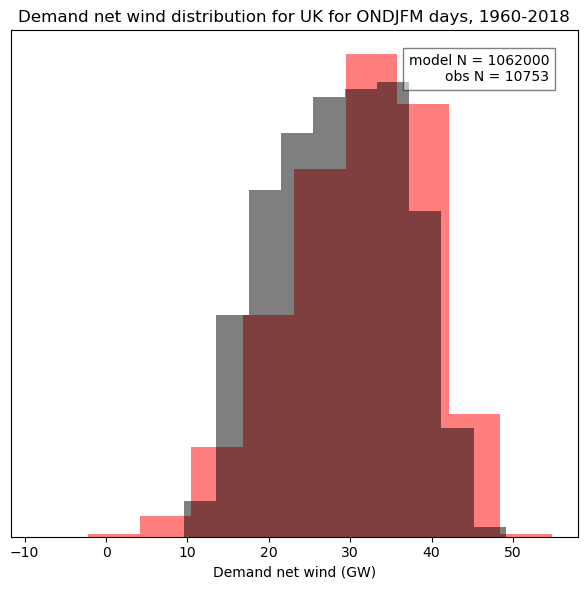

In [40]:
# plot the distributions
funcs.plot_distribution(
    obs_df=df_obs_constraint,
    model_df=df_model_ondjfm,
    xlabel="Demand net wind (GW)",
    nbins=50,
    title=f"Demand net wind distribution for UK for ONDJFM days, 1960-2018",
    obs_val_name="wd_demand_net_wind",
    model_val_name="wd_demand_net_wind_pred",
    fname_prefix="distribution_uk_dnw_ondjfm_1960-2018",
    save_dir="/gws/nopw/j04/canari/users/benhutch/plots/unseen",
)

In [41]:
import importlib

importlib.reload(funcs)

<module 'functions' from '/home/users/benhutch/unseen_functions/functions.py'>

Calculating bootstrap statistics:  10%|█         | 1/10 [00:00<00:01,  7.94it/s]

Calculating bootstrap statistics: 100%|██████████| 10/10 [00:01<00:00,  7.10it/s]


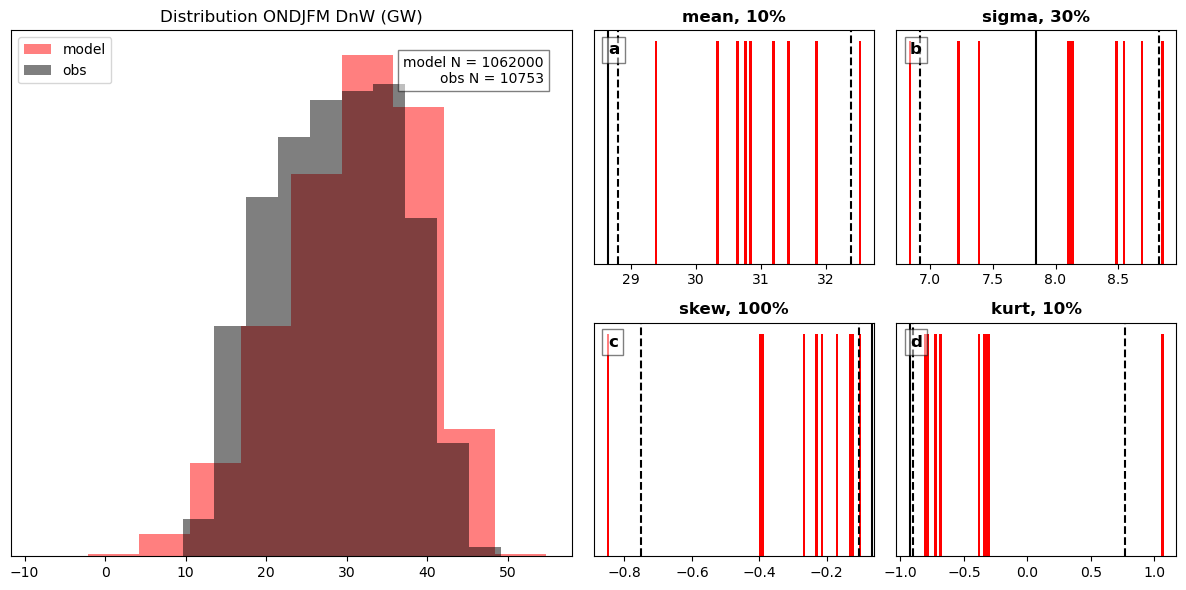

In [42]:
funcs.plot_distributions_fidelity(
    obs_df=df_obs_constraint,
    model_df=df_model_ondjfm,
    obs_val_name="wd_demand_net_wind",
    model_val_name="wd_demand_net_wind_pred",
    obs_time_name="date",
    model_time_name="init_year",
    model_member_name="member",
    model_lead_name="lead",
    title="Distribution ONDJFM DnW (GW)",
    nboot=10, # for testing purposes
    figsize=(12, 6),
    fname_prefix="distribution_uk_dnw_ondjfm_1960-2018",
    save_dir="/gws/nopw/j04/canari/users/benhutch/plots/unseen",
)

The ks stat is 0.12117045941543403
The ks p is 1.1693478435909183e-136
at alpha = 0.05, the critical value is 0.013181404756669374
at alpha = 0.01, the critical value is 0.01579830128924344
The null hypothesis is rejected at the 1% level
The two samples are not drawn from the same distribution
The null hypothesis is rejected at the 1% level
The two samples are not drawn from the same distribution


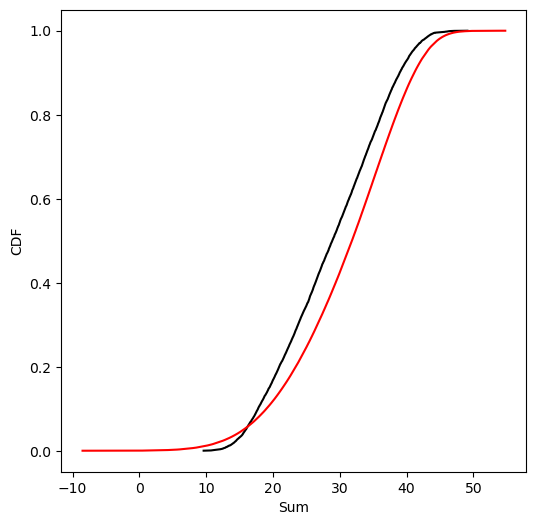

In [43]:
funcs.plot_cdfs(
    obs_df=df_obs_constraint,
    model_df=df_model_ondjfm,
    obs_val_name="wd_demand_net_wind",
    model_val_name="wd_demand_net_wind_pred",
    save_prefix="cdf_uk_dnw_ondjfm_1960-2018_daily",
    save_dir="/gws/nopw/j04/canari/users/benhutch/plots/unseen",
)

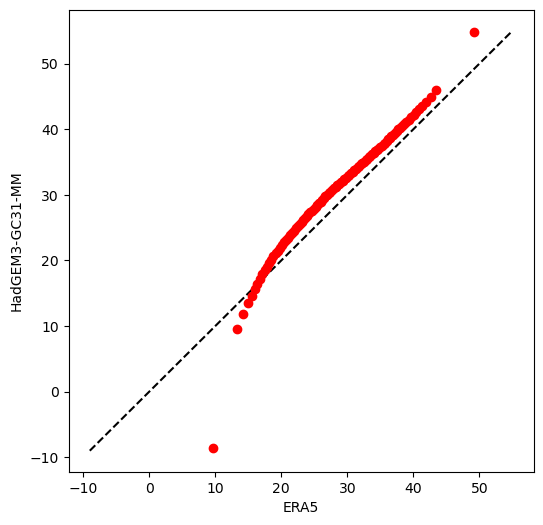

In [44]:
funcs.plot_qq(
    obs_df=df_obs_constraint,
    model_df=df_model_ondjfm,
    obs_val_name="wd_demand_net_wind",
    model_val_name="wd_demand_net_wind_pred",
    save_prefix="qq_uk_dnw_ondjfm_1960-2018_daily",
    save_dir="/gws/nopw/j04/canari/users/benhutch/plots/unseen",
)

In [45]:
# # make index col into a seperate column
# df_obs_constraint.reset_index(inplace=True)

In [46]:
df_obs_constraint.head()

,date,solar_power,100m_wind_speed,10m_wind_speed,solar_irradiance,ofs_cfs,ons_cfs,t2m_no_detrend,t2m_2020_detrend,United_Kingdom_demand,United_Kingdom_wd_demand,wind_gen,demand_net_wind,wd_demand_net_wind
0,1960-01-01,0.017302,7.625868,5.137020,47.696808,0.766016,0.298726,6.577980,7.835584,40.766836,41.666578,15.744187,25.022648,25.922391
1,1960-01-02,0.016300,4.930154,3.186221,44.535210,0.161353,0.101100,3.956466,5.214012,40.019199,43.863111,3.883881,36.135318,39.979230
2,1960-01-03,0.014511,7.249626,4.753627,39.765705,0.298246,0.266276,5.730921,6.988410,37.949476,42.640292,8.359369,29.590107,34.280923
3,1960-01-04,0.016632,9.558028,6.228839,46.044937,0.526643,0.363619,7.894082,9.151514,39.775870,40.584140,13.176714,26.599156,27.407426
4,1960-01-05,0.026247,8.874397,6.005377,71.949350,0.798906,0.376032,5.362875,6.620249,42.761398,42.761398,17.378747,25.382651,25.382651


The mean bias is 2.1817231682308824
The spread bias is 0.6357127526922284
The number of unique model times is 59
The number of unique obs times is 10753


Calculating bootstrap statistics:  10%|█         | 1/10 [00:00<00:01,  7.29it/s]

Calculating bootstrap statistics: 100%|██████████| 10/10 [00:01<00:00,  7.47it/s]


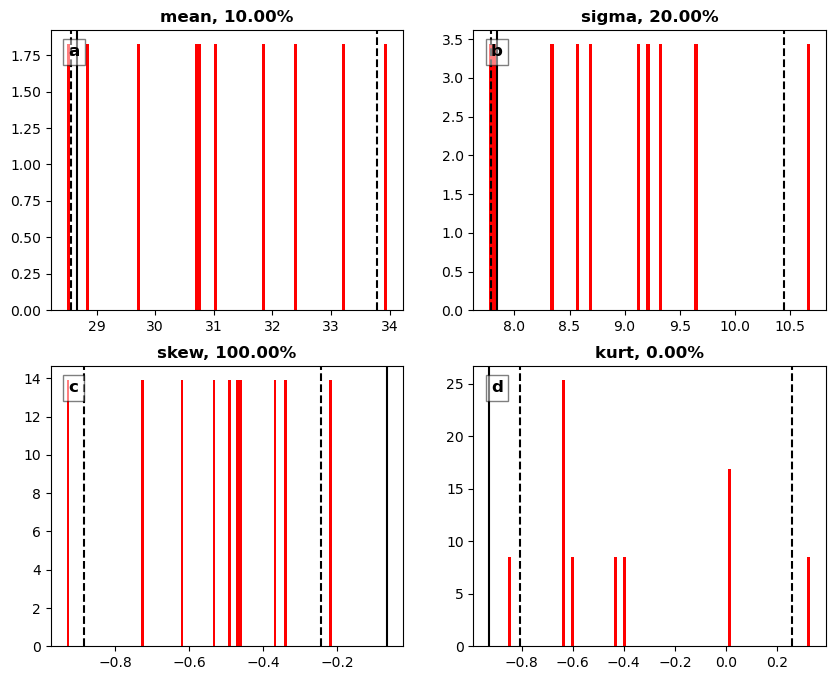

In [47]:
funcs.plot_fidelity(
    obs_df=df_obs_constraint,
    model_df=df_model_ondjfm,
    obs_val_name="wd_demand_net_wind",
    model_val_name="wd_demand_net_wind_pred",
    obs_time_name="date",
    model_time_name="init_year",
    model_member_name="member",
    model_lead_name="lead",
    nboot=10,
    figsize=(10, 8),
    save_dir="/gws/nopw/j04/canari/users/benhutch/plots/unseen",
    fname_root="fidelity_uk_dnw_ondjfm_1960-2018_daily_nboot_10000",
)

In [48]:
# set up the obs val name
obs_val_name = "wd_demand_net_wind"
model_val_name = "wd_demand_net_wind_pred"
variable = "Demand net wind (GW)"

Text(0.5, 1.0, 'Boxplots of Demand net wind (GW) for United Kingdom ONDJFM 1960-2018 HadGEM3-GC31-MM dcppA-hindcast day')

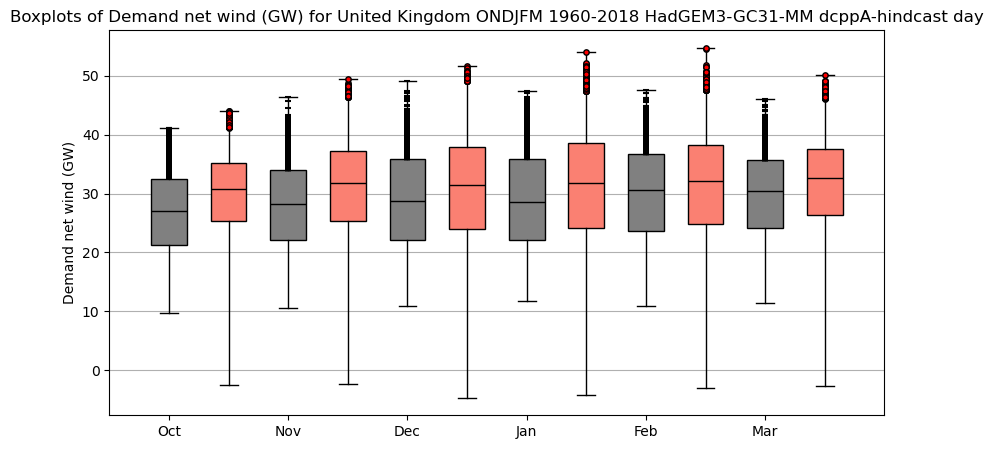

In [49]:
# plot the boxplots for the different months
# set up the figure size
plt.figure(figsize=(10, 5))

# Set up the month names for the x-axis
month_names = ["Oct", "Nov", "Dec", "Jan", "Feb", "Mar"]

# Set up the ylabel
plt.ylabel(f"{variable}")

# Set up the lead_years
lead_years = np.arange(1, 11)

# set ip the months
months = [10, 11, 12, 1, 2, 3]

# assert that months is 10, 11, 12, 1, 2, 3
assert months == [10, 11, 12, 1, 2, 3], "Months not recognised"

# # if variable is tas, convert to C
# if variable == "tas":
#     df_obs_constraint[obs_val_name] = df_obs_constraint[obs_val_name] - 273.15
#     df_model_ondjfm[model_val_name] = df_model_ondjfm[model_val_name] - 273.15

# Loop over the months
for i, month in enumerate(months):
    # subset to the month
    obs_df_month = df_obs_constraint[df_obs_constraint["date"].dt.month == month]

    leads_this_month = []

    # find the leads to extract
    for j, ly in enumerate(lead_years):
        # set up the leads
        leads_this_month = np.arange(331 + (j * 360) + (i * 30), 331 + 30 + (j * 360) + (i * 30))


    # subset to the leads
    model_df_month = df_model_ondjfm[df_model_ondjfm["lead"].isin(leads_this_month)]

    # Calculate the upper quartile (75th percentile)
    obs_lower_quartile = np.percentile(obs_df_month[obs_val_name], 25)
    obs_upper_quartile = np.percentile(obs_df_month[obs_val_name], 75)
    model_lower_quartile = np.percentile(model_df_month[model_val_name], 25)

    # calculate the obs min value for the month
    obs_min = np.min(obs_df_month[obs_val_name])
    obs_max = np.max(obs_df_month[obs_val_name])

    # Plot the observed data in black
    obs_box = plt.boxplot(
        obs_df_month[obs_val_name],
        positions=[i + 1],
        widths=0.3,
        showfliers=False,
        boxprops=dict(color='black'),
        capprops=dict(color='black'),
        whiskerprops=dict(color='black'),
        flierprops=dict(markerfacecolor='black', marker='o'),
        medianprops=dict(color='black'),
        whis=[0, 100], # the 0th and 100th percentiles (i.e. min and max)
        patch_artist=True
    )

    # Set the face color for the observed data box
    for box in obs_box['boxes']:
        box.set(facecolor='grey')

    # Plot the model data in red
    model_box = plt.boxplot(
        model_df_month[model_val_name],
        positions=[i + 1.5],
        widths=0.3,
        showfliers=False,
        boxprops=dict(color='black'),
        capprops=dict(color='black'),
        whiskerprops=dict(color='black'),
        flierprops=dict(markerfacecolor='black', marker='o'),
        medianprops=dict(color='black'),
        whis=[0, 100], # the 0th and 100th percentiles (i.e. min and max)
        patch_artist=True,
    )

    # Set the face color for the model data box
    for box in model_box['boxes']:
        box.set(facecolor='salmon')    

    # add scatter points for obs values beneath the lower quartile
    obs_below_lower_quartile = obs_df_month[obs_val_name][obs_df_month[obs_val_name] < obs_lower_quartile]
    obs_above_upper_quartile = obs_df_month[obs_val_name][obs_df_month[obs_val_name] > obs_upper_quartile]

    plt.scatter(
        [i + 1] * len(obs_above_upper_quartile),
        obs_above_upper_quartile,
        color="black",
        marker="_",
        s=15,
        zorder=10,
    )

    # # add scatter points for model values beneath the lower quartile
    # model_below_lower_quartile = model_df_month[model_val_name][model_df_month[model_val_name] < model_lower_quartile]
    # plt.scatter(
    #     [i + 1.5] * len(model_below_lower_quartile),
    #     model_below_lower_quartile,
    #     color="red",
    #     marker="_",
    #     s=20,
    # )

    # add red dots for the points which are lower than the obs min
    model_below_obs_min = model_df_month[model_val_name][model_df_month[model_val_name] < obs_min]
    model_above_obs_max = model_df_month[model_val_name][model_df_month[model_val_name] > obs_max]

    # plot the model data
    plt.scatter(
        [i + 1.5] * len(model_above_obs_max),
        model_above_obs_max,
        color="red",
        edgecolor="black",
        marker="o",
        s=15,
        zorder=10,
    )

# include gridlines
plt.grid(axis="y")

# set the xticks
plt.xticks(ticks=np.arange(1, 7), labels=month_names)

# Set up the season
season = "ONDJFM"
first_year = 1960
last_year = 2018

# set the title
plt.title(f"Boxplots of {variable} for {country} {season} {first_year}-{last_year} HadGEM3-GC31-MM {experiment} {freq}")

In [50]:
import numpy as np
from scipy.stats import percentileofscore

# Given value
value = 40

# Calculate the percentile rank of the given value in the dataset
percentile_rank = percentileofscore(df_obs_constraint["wd_demand_net_wind"], value)

print(f"The value {value} GW corresponds to the {percentile_rank}th percentile.")

The value 40 GW corresponds to the 92.86710685390123th percentile.


In [51]:
df_obs_constraint = df_obs_constraint.set_index("date")

In [52]:
# Therefore use the 92th percentile for exceedance
# loop over the winter years
winter_years = np.arange(1960, 2018 + 1)

# Set up an array to store the severity index
severity_index = np.zeros(len(winter_years))

# Set up an array to store the no. exceedance days
no_exceedance_days = np.zeros(len(winter_years))

# Set up an empty list for the dates
dates_exceedance_values = []
exceedance_values = []
winter_mean_dnw = []

all_winters_92 = np.percentile(df_obs_constraint["wd_demand_net_wind"], 92)

# loop over the winter years
for i, year in enumerate(winter_years):
    # Set up the first and last day of the winter
    winter_start = pd.Timestamp(f"{year}-10-01")
    winter_end = pd.Timestamp(f"{year+1}-03-31")

    # subset the data
    df = df_obs_constraint.loc[winter_start:winter_end]

    # if df includes 29th feb, then drop this row
    if f"{year + 1}-02-29" in df.index:
        print("Dropping 29th Feb")
        df = df.drop(pd.Timestamp(f"{year + 1}-02-29"))

    # apply a boolean mask to the demand net wind value
    # which is true where the demand net wind is greater than the 80% tile value
    mask = df["wd_demand_net_wind"] > all_winters_92

    # # plot the data as a grey line
    # ax.plot(index_date, df["wd_demand_net_wind"], color="grey", alpha=0.2)

    # # plot the masked values as red dots
    # ax.plot(index_date[mask], df["wd_demand_net_wind"][mask], "rx")

    # calculate the severity index
    severity_index[i] = (df["wd_demand_net_wind"][mask] - all_winters_92).sum()

    # calculate the no. exceedance days
    no_exceedance_days[i] = mask.sum()

    # calculate the mean demand net wind for the winter
    winter_mean_dnw.append(df["wd_demand_net_wind"].mean())

    # format the dates to yyyy-mm-dd
    dates = df.index[mask].strftime("%Y-%m-%d")

    # Add the dates and values to the list
    dates_exceedance_values.extend(df.index[mask])

    # Add the exceedance values to the list
    exceedance_values.extend(df["wd_demand_net_wind"][mask])

# set up a dataframe for the number of exceedance days
df_exceedance_days_obs = pd.DataFrame(
    {
        "severity": severity_index,
        "no_exceedance_days": no_exceedance_days,
        "winter_mean_dnw": winter_mean_dnw,
    },
    index=winter_years,
)

Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb


In [53]:
# print the row with the max value of severity
print(df_exceedance_days_obs.loc[df_exceedance_days_obs["severity"].idxmax()])

severity              130.330120
no_exceedance_days     38.000000
winter_mean_dnw        32.978647
Name: 1962, dtype: float64


In [54]:
# print the row with the max value of no exceedance days
print(df_exceedance_days_obs.loc[df_exceedance_days_obs["no_exceedance_days"].idxmax()])

severity              130.330120
no_exceedance_days     38.000000
winter_mean_dnw        32.978647
Name: 1962, dtype: float64


In [55]:
# print the row with the max value of winter mean dnw
print(df_exceedance_days_obs.loc[df_exceedance_days_obs["winter_mean_dnw"].idxmax()])

severity              130.330120
no_exceedance_days     38.000000
winter_mean_dnw        32.978647
Name: 1962, dtype: float64


In [56]:
df_model_ondjfm.head()

,index,init_year,member,lead,UK_tas,UK_sfcWind,wd_demand_net_wind_pred,wd_demand_net_wind_pred_05,wd_demand_net_wind_pred_95
0,330,1960,1,331,10.194633,4.469876,29.406513,25.395432,33.447464
1,331,1960,1,332,11.097110,5.489894,24.900745,21.244807,28.675174
2,332,1960,1,333,11.798156,6.172364,21.809717,18.026866,25.794070
3,333,1960,1,334,11.379038,4.134217,29.726259,25.754125,33.863978
4,334,1960,1,335,11.771268,4.603901,27.669820,23.773750,31.607102


In [57]:
# subset the model to the correct years
winter_years = np.arange(1, 10 + 1)

# set up a new df to append to
df_model_ondjfm_wyear = pd.DataFrame()

# Loop over the winter years
for i, wyear in enumerate(winter_years):
    # Set up the leads to extract
    leads = np.arange(331 + (i * 360), 331 + 180 + (i * 360))

    # Extract the data
    df_model_leads_this = df_model_ondjfm[df_model_ondjfm["lead"].isin(leads)]

    # include a new column containing the winter year
    df_model_leads_this["winter_year"] = wyear

    # Append to the new df
    df_model_ondjfm_wyear = pd.concat([df_model_ondjfm_wyear, df_model_leads_this])

/tmp/ipykernel_1302765/1433218824.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model_leads_this["winter_year"] = wyear
/tmp/ipykernel_1302765/1433218824.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model_leads_this["winter_year"] = wyear
/tmp/ipykernel_1302765/1433218824.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

In [58]:
df_model_ondjfm_wyear.head()

,index,init_year,member,lead,UK_tas,UK_sfcWind,wd_demand_net_wind_pred,wd_demand_net_wind_pred_05,wd_demand_net_wind_pred_95,winter_year
0,330,1960,1,331,10.194633,4.469876,29.406513,25.395432,33.447464,1
1,331,1960,1,332,11.097110,5.489894,24.900745,21.244807,28.675174,1
2,332,1960,1,333,11.798156,6.172364,21.809717,18.026866,25.794070,1
3,333,1960,1,334,11.379038,4.134217,29.726259,25.754125,33.863978,1
4,334,1960,1,335,11.771268,4.603901,27.669820,23.773750,31.607102,1


In [59]:
# Apply a mean bias correction to the model data
# Calculate the mean bias
mean_bias = df_obs_constraint["wd_demand_net_wind"].mean() - df_model_ondjfm_wyear["wd_demand_net_wind_pred"].mean()

# Apply the mean bias correction
df_model_ondjfm_wyear["wd_demand_net_wind_pred_bc"] = df_model_ondjfm_wyear["wd_demand_net_wind_pred"] + mean_bias

# apply this corrected to the 05 and 95 percentiles
df_model_ondjfm_wyear["wd_demand_net_wind_pred_05_bc"] = df_model_ondjfm_wyear["wd_demand_net_wind_pred_05"] + mean_bias
df_model_ondjfm_wyear["wd_demand_net_wind_pred_95_bc"] = df_model_ondjfm_wyear["wd_demand_net_wind_pred_95"] + mean_bias

In [60]:
# Extract the unique init years
init_years = df_model_ondjfm_wyear["init_year"].unique()
members = df_model_ondjfm_wyear["member"].unique()
winter_years = df_model_ondjfm_wyear["winter_year"].unique()

# Set up an array to store the severity index
model_severity_index = np.zeros([len(init_years), len(members), len(winter_years)])
model_severity_index_05 = np.zeros([len(init_years), len(members), len(winter_years)])
model_severity_index_95 = np.zeros([len(init_years), len(members), len(winter_years)])
model_no_exceedance_days = np.zeros([len(init_years), len(members), len(winter_years)])
model_no_exceedance_days_05 = np.zeros([len(init_years), len(members), len(winter_years)])
model_no_exceedance_days_95 = np.zeros([len(init_years), len(members), len(winter_years)])

# Set up an empty list for the dates
model_dates_exceedance_values = []
model_exceedance_values = []
winter_mean_dnw = []

# for the 05 and 95 percentiles
model_exceedance_values_05 = [] ; model_exceedance_values_95 = []
winter_mean_dnw_05 = [] ; winter_mean_dnw_95 = []

# Set up an empty df
df_model_exceedance = pd.DataFrame()

# loop over the init years
for i, i_year in enumerate(init_years):
    for j, member in enumerate(members):
        for k, w_year in enumerate(winter_years):
            # Constrain to the init year, member and winter year
            df_this = df_model_ondjfm_wyear[
                (df_model_ondjfm_wyear["init_year"] == i_year)
                & (df_model_ondjfm_wyear["member"] == member)
                & (df_model_ondjfm_wyear["winter_year"] == w_year)
            ]

            # apply a boolean mask to the demand net wind value
            # which is true where the demand net wind is greater than the 80% tile value
            mask = df_this["wd_demand_net_wind_pred_bc"] > all_winters_92
            mask_05 = df_this["wd_demand_net_wind_pred_05_bc"] > all_winters_92
            mask_95 = df_this["wd_demand_net_wind_pred_95_bc"] > all_winters_92

            # calculate the severity index
            model_severity_index[i, j, k] = (df_this["wd_demand_net_wind_pred_bc"][mask] - all_winters_92).sum()
            model_severity_index_05[i, j, k] = (df_this["wd_demand_net_wind_pred_05_bc"][mask_05] - all_winters_92).sum()
            model_severity_index_95[i, j, k] = (df_this["wd_demand_net_wind_pred_95_bc"][mask_95] - all_winters_92).sum()

            # calculate the no. exceedance days
            model_no_exceedance_days[i, j, k] = mask.sum()
            model_no_exceedance_days_05[i, j, k] = mask_05.sum()
            model_no_exceedance_days_95[i, j, k] = mask_95.sum()

            # winter mean values
            winter_mean_dnw.append(df_this["wd_demand_net_wind_pred_bc"].mean())
            winter_mean_dnw_05.append(df_this["wd_demand_net_wind_pred_05_bc"].mean())
            winter_mean_dnw_95.append(df_this["wd_demand_net_wind_pred_95_bc"].mean())

            # Set up the df
            df_this_exceedance = pd.DataFrame(
                {
                    "init_year": [i_year],
                    "member": [member],
                    "winter_year": [w_year],
                    "severity": [model_severity_index[i, j, k]],
                    "severity_05": [model_severity_index_05[i, j, k]],
                    "severity_95": [model_severity_index_95[i, j, k]],
                    "no_exceedance_days": [model_no_exceedance_days[i, j, k]],
                    "no_exceedance_days_05": [model_no_exceedance_days_05[i, j, k]],
                    "no_exceedance_days_95": [model_no_exceedance_days_95[i, j, k]],
                    "winter_mean_dnw": [df_this["wd_demand_net_wind_pred_bc"].mean()],
                    "winter_mean_dnw_05": [df_this["wd_demand_net_wind_pred_05_bc"].mean()],
                    "winter_mean_dnw_95": [df_this["wd_demand_net_wind_pred_95_bc"].mean()],
                }
            )

            # Append to the df
            df_model_exceedance = pd.concat([df_model_exceedance, df_this_exceedance])

In [61]:
df_model_exceedance.tail()

,init_year,member,winter_year,severity,severity_05,severity_95,no_exceedance_days,no_exceedance_days_05,no_exceedance_days_95,winter_mean_dnw,winter_mean_dnw_05,winter_mean_dnw_95
0,2018,10,6,38.970242,2.023246,154.654882,21.0,1.0,38.0,27.248570,23.289202,31.217382
0,2018,10,7,9.154422,0.000000,76.082131,6.0,0.0,30.0,27.488684,23.560638,31.444876
0,2018,10,8,18.627207,0.911373,136.603347,11.0,1.0,47.0,29.432052,25.483870,33.385924
0,2018,10,9,10.550403,0.000000,97.944906,9.0,0.0,39.0,29.962998,26.021995,33.897971
0,2018,10,10,19.082042,0.000000,123.489541,12.0,0.0,43.0,29.344161,25.399281,33.293659


In [62]:
# # plot two vertical event plots for the severity and no. exceedance days
# # for both the model and the observed data
# # set up the figure size
# plt.figure(figsize=(10, 5))

# # plot the event plot for the severity index
# plt.subplot(1, 2, 1)

# # plot the observed data
# plt.eventplot(
#     df_exceedance_days_obs["severity"],
#     colors="black",
#     lineoffsets=0,
#     linelengths=0.5,
#     orientation="vertical",
#     linewidths=1,
#     label="Observed",
# )

# # plot the model data
# plt.eventplot(
#     df_model_exceedance["severity"],
#     colors="red",
#     lineoffsets=1,
#     linelengths=0.5,
#     orientation="vertical",
#     linewidths=0.5,
#     label="Model",
# )

# # set the title
# plt.title("Severity index")

# # remove the xlabel
# plt.xlabel("")

# # remove the xticks
# plt.xticks([])

# # for the second subplot
# plt.subplot(1, 2, 2)

# # plot the observed data
# plt.eventplot(
#     df_exceedance_days_obs["no_exceedance_days"],
#     colors="black",
#     lineoffsets=0,
#     linelengths=0.5,
#     orientation="vertical",
#     linewidths=2,
#     label="Observed",
# )

# # plot the model data
# plt.eventplot(
#     df_model_exceedance["no_exceedance_days"],
#     colors="red",
#     lineoffsets=1,
#     linelengths=0.5,
#     orientation="vertical",
#     linewidths=1,
#     label="Model",
# )

# # set the title
# plt.title("No. exceedance days")

# # remove the xlabel
# plt.xlabel("")

# # remove the xticks
# plt.xticks([])

In [63]:
# df_obs_constraint.shape

In [64]:
winter_years = np.arange(1960, 2017 + 1)

In [65]:
df_obs_constraint.head()

,solar_power,100m_wind_speed,10m_wind_speed,solar_irradiance,ofs_cfs,ons_cfs,t2m_no_detrend,t2m_2020_detrend,United_Kingdom_demand,United_Kingdom_wd_demand,wind_gen,demand_net_wind,wd_demand_net_wind
date,,,,,,,,,,,,,
1960-01-01,0.017302,7.625868,5.137020,47.696808,0.766016,0.298726,6.577980,7.835584,40.766836,41.666578,15.744187,25.022648,25.922391
1960-01-02,0.016300,4.930154,3.186221,44.535210,0.161353,0.101100,3.956466,5.214012,40.019199,43.863111,3.883881,36.135318,39.979230
1960-01-03,0.014511,7.249626,4.753627,39.765705,0.298246,0.266276,5.730921,6.988410,37.949476,42.640292,8.359369,29.590107,34.280923
1960-01-04,0.016632,9.558028,6.228839,46.044937,0.526643,0.363619,7.894082,9.151514,39.775870,40.584140,13.176714,26.599156,27.407426
1960-01-05,0.026247,8.874397,6.005377,71.949350,0.798906,0.376032,5.362875,6.620249,42.761398,42.761398,17.378747,25.382651,25.382651


In [66]:
df_model_exceedance.head()

,init_year,member,winter_year,severity,severity_05,severity_95,no_exceedance_days,no_exceedance_days_05,no_exceedance_days_95,winter_mean_dnw,winter_mean_dnw_05,winter_mean_dnw_95
0,1960,1,1,42.273743,1.975495,175.203154,19.0,3.0,49.0,29.752530,25.808225,33.717030
0,1960,1,2,61.316058,4.443635,192.453110,22.0,4.0,49.0,30.682361,26.721806,34.616711
0,1960,1,3,15.983207,0.000000,115.099503,11.0,0.0,42.0,30.098230,26.179694,34.029567
0,1960,1,4,28.605026,1.020949,130.497108,14.0,2.0,41.0,28.622459,24.686803,32.558571
0,1960,1,5,23.879285,0.620298,123.047177,11.0,1.0,41.0,27.897092,23.958414,31.840297


In [67]:
# # Set up the figure
# fig, axs = plt.subplots(
#     nrows=1,
#     ncols=2,
#     figsize=(10, 5),
#     sharey=True,
#     gridspec_kw={"width_ratios": [8, 1]},
# )

# # for the first plot    
# ax = axs[0]

# # # set up the index date
# # index_date = range(pd.Timestamp("1960-10-01").toordinal(), pd.Timestamp("2018-03-31").toordinal() + 1)

# # Extract the unique init years
# init_years = df_model_ondjfm_wyear["init_year"].unique()
# members = df_model_ondjfm_wyear["member"].unique()
# unique_lead_years = df_model_ondjfm_wyear["winter_year"].unique()

# # loop over the init years
# for i, i_year in enumerate(init_years):
#     for j, member in enumerate(members):
#         for k, w_year in enumerate(unique_lead_years):
#             # Constrain to the init year, member and winter year
#             df_model_this = df_model_ondjfm_wyear[
#                 (df_model_ondjfm_wyear["init_year"] == i_year)
#                 & (df_model_ondjfm_wyear["member"] == member)
#                 & (df_model_ondjfm_wyear["winter_year"] == w_year)
#             ]

#             if i == 0 and j == 0 and k == 0:
#                 # Set up the index date
#                 index_date = np.arange(0, len(df_model_this))


#             if i_year == 1971 and member == 5 and w_year == 9:
#                 # plot in a thick black line
#                 ax.plot(
#                     index_date,
#                     df_model_this["wd_demand_net_wind_pred_bc"],
#                     color="red",
#                     alpha=1,
#                     linewidth=2,
#                     label=f"Model",
#                 )
#             else:
#                 # plot the model data
#                 ax.plot(
#                     index_date,
#                     df_model_this["wd_demand_net_wind_pred_bc"],
#                     color="grey",
#                     alpha=0.05,
#                     linewidth=0.25,
#                 )

# # Loop over the winter years
# for i, w_year in enumerate(winter_years):
#     # subset the data
#     winter_obs_start = pd.Timestamp(f"{w_year}-10-01")
#     winter_obs_end = pd.Timestamp(f"{w_year + 1}-03-31")

#     # subset the data
#     df_obs_this = df_obs_constraint.loc[winter_obs_start:winter_obs_end]

#     # # print df obs this
#     # print(df_obs_this)

#     # print the len of df_obs_this
#     print(len(df_obs_this))

#     if f"{w_year + 1}-02-29" in df_obs_this.index:
#         print("Dropping 29th Feb")
#         df_obs_this = df_obs_this.drop(pd.Timestamp(f"{w_year + 1}-02-29"))

#     # if i = 0
#     if i == 0:
#         # Set up the index date
#         index_date = np.arange(0, len(df_obs_this))

#     # if w_year = 1962, plot in a thick black line
#     if w_year == 1962:
#         ax.plot(
#             index_date,
#             df_obs_this["wd_demand_net_wind"],
#             color="black",
#             alpha=1,
#             linewidth=2,
#             label=f"Observations",
#         )

# # on the second plot plot vertical eventsplots for the severity
# ax = axs[1]

# # plot the event plot for the severity index
# ax.eventplot(
#     df_exceedance_days_obs["winter_mean_dnw"],
#     colors="black",
#     lineoffsets=0,
#     linelengths=0.5,
#     orientation="vertical",
#     linewidths=1,
#     label="Observed",
# )

# # plot the model data
# ax.eventplot(
#     df_model_exceedance["winter_mean_dnw"],
#     colors="red",
#     lineoffsets=1,
#     linelengths=0.5,
#     orientation="vertical",
#     linewidths=0.5,
#     label="Model",
# )

In [68]:
# create a new column in df_model_exceedance
# effective dec_year
df_model_exceedance["effective_dec_year"] = df_model_exceedance["init_year"] + df_model_exceedance["winter_year"]

In [69]:
df_model_exceedance["effective_dec_year"].unique()

array([1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971,
       1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982,
       1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
       1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
       2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026,
       2027, 2028])

In [70]:
df_exceedance_days_obs.head()

,severity,no_exceedance_days,winter_mean_dnw
1960,35.786467,18.0,29.328790
1961,73.972244,34.0,29.978915
1962,130.330120,38.0,32.978647
1963,31.710833,20.0,30.731293
1964,37.343381,21.0,31.321400


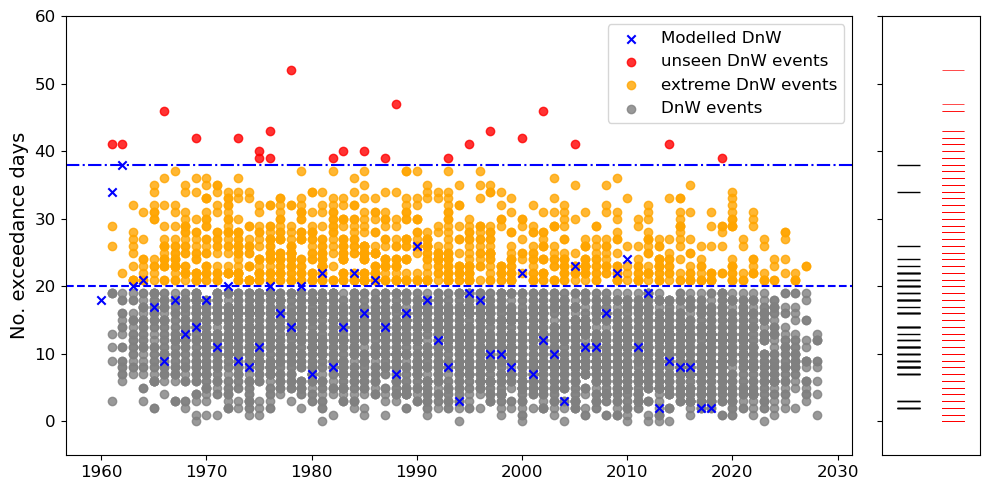

In [71]:
import seaborn as sns

# Set up the figure
fig, axs = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(10, 5),
    sharey=True,
    gridspec_kw={"width_ratios": [8, 1]},
)

# add a horizontal line for the 0.8 quantile of the observations
axs[0].axhline(
    np.quantile(df_exceedance_days_obs["no_exceedance_days"], 0.8),
    color="blue",
    linestyle="--",
)

# for the max value of the obs
axs[0].axhline(
    np.max(df_exceedance_days_obs["no_exceedance_days"]),
    color="blue",
    linestyle="-.",
)

# plot the scatter points for the obs
axs[0].scatter(
    df_exceedance_days_obs.index,
    df_exceedance_days_obs["no_exceedance_days"],
    color="blue",
    marker="x",
    label="Modelled DnW",
    zorder=2,
)

# Separate model data by threshold
very_bad_events = df_model_exceedance[
    df_model_exceedance["no_exceedance_days"] > np.max(df_exceedance_days_obs["no_exceedance_days"])
]

# Model data above 80th percentile
bad_events = df_model_exceedance[
    (df_model_exceedance["no_exceedance_days"] > np.quantile(df_exceedance_days_obs["no_exceedance_days"], 0.8)) &
    (df_model_exceedance["no_exceedance_days"] < np.max(df_exceedance_days_obs["no_exceedance_days"]))
]

# Model data below 80th percentile
events = df_model_exceedance[
    df_model_exceedance["no_exceedance_days"] < np.quantile(df_exceedance_days_obs["no_exceedance_days"], 0.8)
]

# Plot the points below the minimum of the obs
axs[0].scatter(
    very_bad_events["effective_dec_year"],
    very_bad_events["no_exceedance_days"],
    color="red",
    alpha=0.8,
    label="unseen DnW events",
)

# Plot the points below the 20th percentile
axs[0].scatter(
    bad_events["effective_dec_year"],
    bad_events["no_exceedance_days"],
    color="orange",
    alpha=0.8,
    label="extreme DnW events",
)

# Plot the points above the 20th percentile
axs[0].scatter(
    events["effective_dec_year"],
    events["no_exceedance_days"],
    color="grey",
    alpha=0.8,
    label="DnW events",
)

# for the most extreme evnts
# plot the error bars
# axs[0].errorbar(
#     very_bad_events["effective_dec_year"],
#     very_bad_events["no_exceedance_days"],
#     yerr=[
#         very_bad_events["no_exceedance_days"] - very_bad_events["no_exceedance_days_05"],  # lower errors
#         very_bad_events["no_exceedance_days_95"] - very_bad_events["no_exceedance_days"],  # upper errors
#     ],
#     fmt="none",
#     ecolor="red",
#     capsize=5,
#     zorder=1,
# )

# include the legend
axs[0].legend(fontsize=12)

# label the y-axis
axs[0].set_ylabel("No. exceedance days", fontsize=14)

# set up the x-axis

# increase the size of the value labels
axs[0].tick_params(axis="x", labelsize=12)

# same for the y-axis
axs[0].tick_params(axis="y", labelsize=12)

# set up the ylims
axs[0].set_ylim(-5, 60)

# do the events plots for the no. exceedance days on the second plot
axs[1].eventplot(
    df_exceedance_days_obs["no_exceedance_days"],
    colors="black",
    lineoffsets=0,
    linelengths=0.5,
    orientation="vertical",
    linewidths=1,
    label="Observed",
)

# plot the model data
axs[1].eventplot(
    df_model_exceedance["no_exceedance_days"],
    colors="red",
    lineoffsets=1,
    linelengths=0.5,
    orientation="vertical",
    linewidths=0.5,
    label="Model",
)

# # set up the xlabels for the second plot
# xlabels = ["Observed", "Model"]

# # add the xlabels to the second subplot
# axs[1].set_xticks(xlabels)

# # remove the xlabel
# axs[1].set_xlabel("")

# # remove the yticks and axis lin
# axs[1].set_yticks([])

# remove the xticks from the second plot
axs[1].set_xticks([])

# specify a tight layout
plt.tight_layout()

# set up a fname for the plot
fname = "no_exceedance_days_uk_dnw_1960-2018.pdf"

save_dir = "/home/users/benhutch/unseen_multi_year/plots"

# form the savepath
savepath = os.path.join(save_dir, fname)

if not os.path.exists(savepath):
    # save the plot
    plt.savefig(savepath, bbox_inches="tight", dpi=800)


In [78]:
sys.path.append("/home/users/benhutch/unseen_functions")
from functions import plot_rp_extremes

In [73]:
# if there is no column named "index"
if "index" not in df_exceedance_days_obs.columns:
    # reset the index
    df_exceedance_days_obs.reset_index(inplace=True)

In [74]:
# do the same for the model data
df_model_exceedance["effective_dec_year_dt"] = pd.to_datetime(df_model_exceedance["effective_dec_year"], format="%Y")

# format the int column containing 1960, 1961 etc
# as datetime in years
df_exceedance_days_obs["index_dt"] = pd.to_datetime(df_exceedance_days_obs["index"], format="%Y")

In [82]:
import importlib
importlib.reload(funcs)
from functions import plot_rp_extremes

   index    severity  no_exceedance_days  winter_mean_dnw   index_dt
0   1960   35.786467                18.0        29.328790 1960-01-01
1   1961   73.972244                34.0        29.978915 1961-01-01
2   1962  130.330120                38.0        32.978647 1962-01-01
3   1963   31.710833                20.0        30.731293 1963-01-01
4   1964   37.343381                21.0        31.321400 1964-01-01
    index   severity  no_exceedance_days  winter_mean_dnw   index_dt
54   2014  13.792142                 9.0        27.230570 2014-01-01
55   2015  17.992099                 8.0        26.831046 2015-01-01
56   2016  10.460432                 8.0        29.570563 2016-01-01
57   2017   4.222670                 2.0        27.967829 2017-01-01
58   2018   2.972459                 2.0        26.772026 2018-01-01
   init_year  member  winter_year   severity  severity_05  severity_95  \
0       1960       1            1  42.273743     1.975495   175.203154   
0       1960       1    

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [02:31<00:00,  6.62it/s]


Model estimate for obs 99.9th %tile event: 99.30993250939976
Model estimate for obs 99.9th %tile event 2.5th percentile: 99.24943428423369
Model estimate for obs 99.9th %tile event 97.5th percentile: 99.36494562428135
Return period for obs 99.9th %tile event: 144.91336189887267
Return period for obs 99.9th %tile event 2.5th percentile: 133.23283744435562
Return period for obs 99.9th %tile event 97.5th percentile: 157.46683091008583
CPU times: user 2min 31s, sys: 195 ms, total: 2min 31s
Wall time: 2min 32s


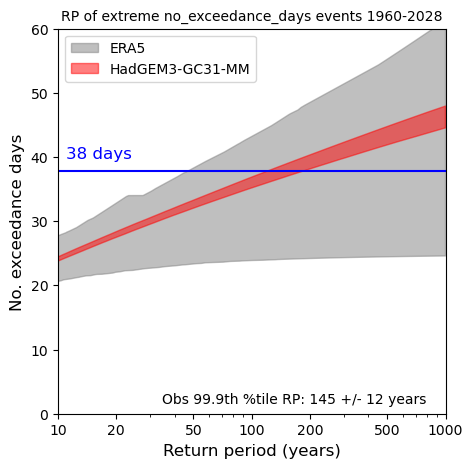

In [88]:
%%time

# Now test the function which does the same
plot_rp_extremes(
    obs_df=df_exceedance_days_obs,
    model_df=df_model_exceedance,
    obs_val_name="no_exceedance_days",
    model_val_name="no_exceedance_days",
    obs_time_name="index_dt",
    model_time_name="effective_dec_year_dt",
    ylim=(0, 60),
    percentile=99.9,
    # years_period=(1960, 1990), # first half
)

In [89]:
%%time

from scipy.stats import genextreme as gev

num_samples = 1000

decades = np.arange(1960, 2030, 10)

decade_years = []

# Set up the decade years
for i, decade in enumerate(decades):
    if i == 0:
        decade_years.append(np.arange(decade, decade + 11))
    else:
        decade_years.append(np.arange(decade + 1, decade + 11))

# Flatten the list of arrays into a single list
flattened_years = np.concatenate(decade_years)

# Filter out the years not in df_model_exceedance["effective_dec_year"].unique()
filtered_years = [year for year in flattened_years if year in df_model_exceedance["effective_dec_year"].unique()]

# Reshape the filtered list back into the original decade structure
filtered_decade_years = []
for i, decade in enumerate(decades):
    if i == 0:
        filtered_decade_years.append(np.array([year for year in filtered_years if 1960 <= year <= 1970]))
    else:
        filtered_decade_years.append(np.array([year for year in filtered_years if decade + 1 <= year <= decade + 10]))

# try the same but with the empirical return levels
# extract the unique winter years from the model df
unique_winter_years = df_model_exceedance["effective_dec_year"].unique()

# find the year of the highest value for no exceedance days
# in the observed data
# Assuming df_exceedance_days_obs is your DataFrame
max_year = df_exceedance_days_obs.loc[
    df_exceedance_days_obs["no_exceedance_days"].idxmax()
].name

# Print the max year
print("The year with the greatest no. exceedance days is: ", max_year)
print("The value is: ", df_exceedance_days_obs["no_exceedance_days"].max())

# set up params year
decade_params = np.zeros([len(filtered_decade_years), num_samples, 3])

# Loop over the unique winter years
for i, decade in tqdm(enumerate(filtered_decade_years)):
    # Subset the model data to the decade years
    df_model_exceedance_this = df_model_exceedance[
        df_model_exceedance["effective_dec_year"].isin(decade)
    ]

    # initialise the list of params
    params_decade = np.zeros([num_samples, 3])

    # Loop over the samples
    for j in range(num_samples):
        params_decade[j, :] = gev.fit(
            np.random.choice(
                df_model_exceedance_this["no_exceedance_days"],
                size=len(df_model_exceedance_this),
                replace=True,
            )
        )

    # append the params to the model year
    decade_params[i, :, :] = params_decade

The year with the greatest no. exceedance days is:  2
The value is:  38.0


7it [06:12, 53.18s/it]

CPU times: user 6min 10s, sys: 38.4 ms, total: 6min 10s
Wall time: 6min 12s


In [91]:
sys.path.append("/home/users/benhutch/unseen_functions")
from functions import estimate_period

In [92]:
# Set up the array for mean, 2.5th and 97.5th percentiles
period_decade_mean = np.zeros([len(filtered_decade_years)])
period_decade_025 = np.zeros([len(filtered_decade_years)])
period_decade_975 = np.zeros([len(filtered_decade_years)])

# find the value for the observed worst event
obs_worst_event = df_exceedance_days_obs["no_exceedance_days"].max()

# find the value for the obs 99th percentile event
obs_99_event = np.percentile(df_exceedance_days_obs["no_exceedance_days"], 99)

# loop over the unique years to fit the ppfs
for i, decade in tqdm(enumerate(filtered_decade_years)):
    # Subset the params for the decade
    params_decade = decade_params[i, :, :]

    # Estimate the period for the model mean data
    period_decade_mean[i] = estimate_period(
        return_level=obs_99_event,
        loc=np.mean(params_decade[:, 1]),
        scale=np.mean(params_decade[:, 2]),
        shape=np.mean(params_decade[:, 0]),
    )

    # model 025 percentile
    period_decade_025[i] = estimate_period(
        return_level=obs_99_event,
        loc=np.percentile(params_decade[:, 1], 2.5),
        scale=np.percentile(params_decade[:, 2], 2.5),
        shape=np.percentile(params_decade[:, 0], 2.5),
    )

    # model 95 percentile
    period_decade_975[i] = estimate_period(
        return_level=obs_99_event,
        loc=np.percentile(params_decade[:, 1], 97.5),
        scale=np.percentile(params_decade[:, 2], 97.5),
        shape=np.percentile(params_decade[:, 0], 97.5),
    )

# put these into a dataframe with the years
model_df_rl = pd.DataFrame(
    {
        "decade": decades,
        "mean": period_decade_mean,
        "025": period_decade_025,
        "975": period_decade_975,
    }
)

7it [00:00, 1143.44it/s]


In [93]:
# for each row of "mean", "025", "975" calculate the return period
# 1 / (1 - (100 - value))
model_df_rl["mean_rp (%)"] = 1 - (model_df_rl["mean"] / 100)
model_df_rl["025_rp (%)"] = 1 - (model_df_rl["025"] / 100)
model_df_rl["975_rp (%)"] = 1 - (model_df_rl["975"] / 100)

# calculate the return period in years of the observed worst event
model_df_rl["mean_rp (years)"] = 1 / model_df_rl["mean_rp (%)"]
model_df_rl["025_rp (years)"] = 1 / model_df_rl["025_rp (%)"]
model_df_rl["975_rp (years)"] = 1 / model_df_rl["975_rp (%)"]

The year with the greatest no_exceedance_days index is:  2


Text(0.5, 1.0, 'Return period of the 99th percentile no. exceedance days event (36 days)')

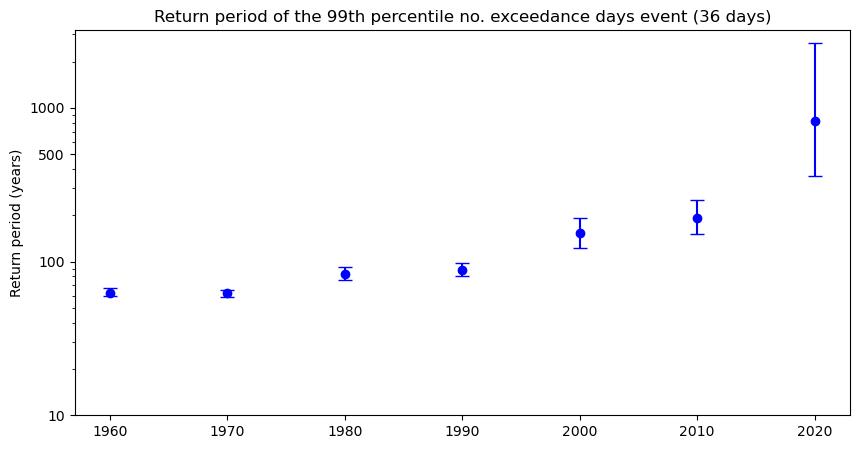

In [98]:
# plot the mean rp values with error bars for the 025 and 975 percentiles
plt.figure(figsize=(10, 5))

# plot the mean
plt.scatter(
    model_df_rl["decade"],
    model_df_rl["mean_rp (years)"],
    color="blue",
    label="Mean",
)

# plot the 025 and 975 percentiles
plt.errorbar(
    model_df_rl["decade"],
    model_df_rl["mean_rp (years)"],
    yerr=[
        model_df_rl["mean_rp (years)"] - model_df_rl["025_rp (years)"], # lower errors
        model_df_rl["975_rp (years)"] - model_df_rl["mean_rp (years)"], # upper errors
    ],
    fmt="none",
    ecolor="blue",
    capsize=5,
)

# fit a trend line to the model data
model_trend = np.polyfit(
    model_df_rl["decade"],
    np.log10(model_df_rl["mean_rp (years)"]),
    1,
)

# # plot the trend line as a dashed line
# plt.plot(
#     model_df_rl["decade"],
#     10 ** np.polyval(model_trend, model_df_rl["decade"]),
#     color="blue",
#     linestyle="--",
# )

# set up a log yscale
plt.yscale("log")

# Set up the y ticks
plt.yticks([10, 100, 500, 1000], labels=["10", "100", "500", "1000"])

# set up the y axis labels
plt.ylabel("Return period (years)")

# find the year of the highest value for no exceedance days
# in the observed data
max_year = df_exceedance_days_obs.loc[
    df_exceedance_days_obs["no_exceedance_days"].idxmax()
].name

# print max year
print("The year with the greatest no_exceedance_days index is: ", max_year)

# # set up the title
# Set up the title
plt.title(
    f"Return period of the 99th percentile no. exceedance days event ({round(obs_99_event)} days)",
)

In [84]:
# print the value of the 99th percentile of no exceedance days
print(f"The 99th percentile of no exceedance days is {np.percentile(df_exceedance_days_obs['no_exceedance_days'], 99)}")

The 99th percentile of no exceedance days is 35.68000000000001


In [87]:
# print the 99.8th percentile of no exceedance days
print(f"The 99.8th percentile of no exceedance days is {np.percentile(df_exceedance_days_obs['no_exceedance_days'], 99.9)}")

The 99.8th percentile of no exceedance days is 37.76800000000003


In [85]:
# print the max value of exceedance days for the obs
print(f"The max value of no exceedance days is {df_exceedance_days_obs['no_exceedance_days'].max()}")

The max value of no exceedance days is 38.0


In [71]:
df_exceedance_days_obs.head()

,severity,no_exceedance_days,winter_mean_dnw
1960,35.786467,18.0,29.328790
1961,73.972244,34.0,29.978915
1962,130.330120,38.0,32.978647
1963,31.710833,20.0,30.731293
1964,37.343381,21.0,31.321400


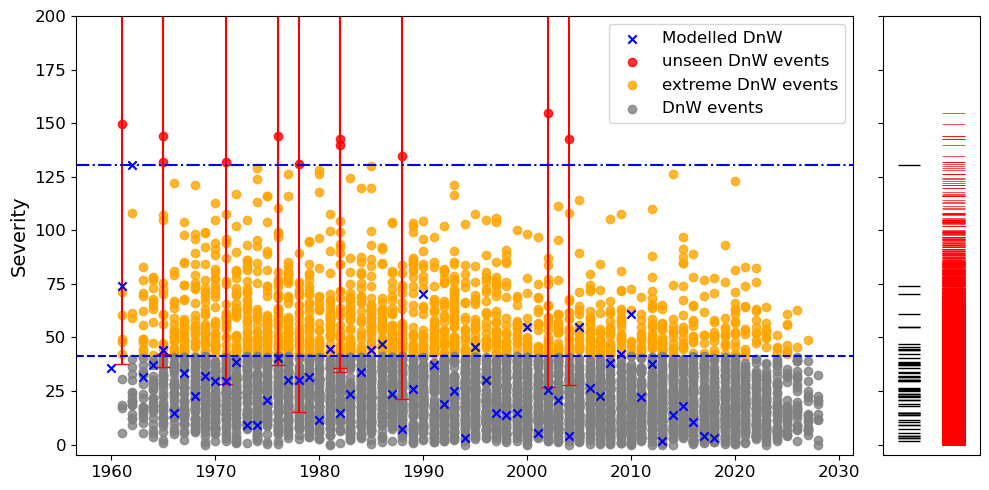

In [72]:
import seaborn as sns

# Set up the figure
fig, axs = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(10, 5),
    sharey=True,
    gridspec_kw={"width_ratios": [8, 1]},
)

# add a horizontal line for the 0.8 quantile of the observations
axs[0].axhline(
    np.quantile(df_exceedance_days_obs["severity"], 0.8),
    color="blue",
    linestyle="--",
)

# for the max value of the obs
axs[0].axhline(
    np.max(df_exceedance_days_obs["severity"]),
    color="blue",
    linestyle="-.",
)

# plot the scatter points for the obs
axs[0].scatter(
    df_exceedance_days_obs.index,
    df_exceedance_days_obs["severity"],
    color="blue",
    marker="x",
    label="Modelled DnW",
    zorder=2,
)

# Separate model data by threshold
very_bad_events = df_model_exceedance[
    df_model_exceedance["severity"] > np.max(df_exceedance_days_obs["severity"])
]

# Model data above 80th percentile
bad_events = df_model_exceedance[
    (df_model_exceedance["severity"] > np.quantile(df_exceedance_days_obs["severity"], 0.8)) &
    (df_model_exceedance["severity"] < np.max(df_exceedance_days_obs["severity"]))
]

# Model data below 80th percentile
events = df_model_exceedance[
    df_model_exceedance["severity"] < np.quantile(df_exceedance_days_obs["severity"], 0.8)
]

# Plot the points below the minimum of the obs
axs[0].scatter(
    very_bad_events["effective_dec_year"],
    very_bad_events["severity"],
    color="red",
    alpha=0.8,
    label="unseen DnW events",
)

# Plot the points below the 20th percentile
axs[0].scatter(
    bad_events["effective_dec_year"],
    bad_events["severity"],
    color="orange",
    alpha=0.8,
    label="extreme DnW events",
)

# Plot the points above the 20th percentile
axs[0].scatter(
    events["effective_dec_year"],
    events["severity"],
    color="grey",
    alpha=0.8,
    label="DnW events",
)

# for the most extreme evnts
# plot the error bars
# axs[0].errorbar(
#     very_bad_events["effective_dec_year"],
#     very_bad_events["severity"],
#     yerr=[
#         very_bad_events["severity"] - very_bad_events["severity_05"],  # lower errors
#         very_bad_events["severity_95"] - very_bad_events["severity"],  # upper errors
#     ],
#     fmt="none",
#     ecolor="red",
#     capsize=5,
#     zorder=1,
# )

# include the legend
axs[0].legend(fontsize=12)

# label the y-axis
axs[0].set_ylabel("Severity", fontsize=14)

# set up the x-axis

# increase the size of the value labels
axs[0].tick_params(axis="x", labelsize=12)

# same for the y-axis
axs[0].tick_params(axis="y", labelsize=12)

# set up the ylims
axs[0].set_ylim(-5, 200)

# do the events plots for the no. exceedance days on the second plot
axs[1].eventplot(
    df_exceedance_days_obs["severity"],
    colors="black",
    lineoffsets=0,
    linelengths=0.5,
    orientation="vertical",
    linewidths=1,
    label="Observed",
)

# plot the model data
axs[1].eventplot(
    df_model_exceedance["severity"],
    colors="red",
    lineoffsets=1,
    linelengths=0.5,
    orientation="vertical",
    linewidths=0.5,
    label="Model",
)

# # set up the xlabels for the second plot
# xlabels = ["Observed", "Model"]

# # add the xlabels to the second subplot
# axs[1].set_xticks(xlabels)

# # remove the xlabel
# axs[1].set_xlabel("")

# # remove the yticks and axis lin
# axs[1].set_yticks([])

# remove the xticks from the second plot
axs[1].set_xticks([])

# specify a tight layout
plt.tight_layout()

# set up a fname for the plot
fname = "severity_uk_dnw_1960-2018.pdf"

save_dir = "/home/users/benhutch/unseen_multi_year/plots"

# form the savepath
savepath = os.path.join(save_dir, fname)

if not os.path.exists(savepath):
    # save the plot
    plt.savefig(savepath, bbox_inches="tight", dpi=800)


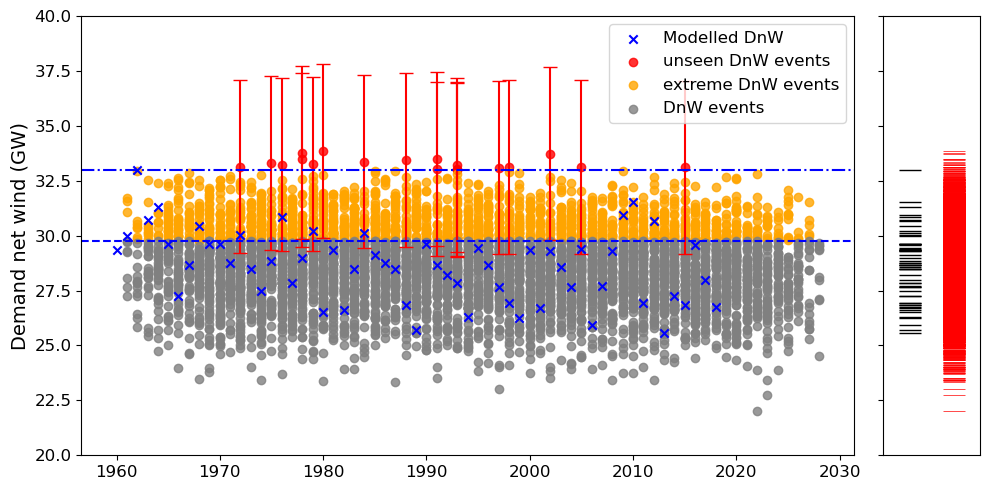

In [73]:
import seaborn as sns

# Set up the figure
fig, axs = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(10, 5),
    sharey=True,
    gridspec_kw={"width_ratios": [8, 1]},
)

# add a horizontal line for the 0.8 quantile of the observations
axs[0].axhline(
    np.quantile(df_exceedance_days_obs["winter_mean_dnw"], 0.8),
    color="blue",
    linestyle="--",
)

# for the max value of the obs
axs[0].axhline(
    np.max(df_exceedance_days_obs["winter_mean_dnw"]),
    color="blue",
    linestyle="-.",
)

# plot the scatter points for the obs
axs[0].scatter(
    df_exceedance_days_obs.index,
    df_exceedance_days_obs["winter_mean_dnw"],
    color="blue",
    marker="x",
    label="Modelled DnW",
    zorder=2,
)

# Separate model data by threshold
very_bad_events = df_model_exceedance[
    df_model_exceedance["winter_mean_dnw"] > np.max(df_exceedance_days_obs["winter_mean_dnw"])
]

# Model data above 80th percentile
bad_events = df_model_exceedance[
    (df_model_exceedance["winter_mean_dnw"] > np.quantile(df_exceedance_days_obs["winter_mean_dnw"], 0.8)) &
    (df_model_exceedance["winter_mean_dnw"] < np.max(df_exceedance_days_obs["winter_mean_dnw"]))
]

# Model data below 80th percentile
events = df_model_exceedance[
    df_model_exceedance["winter_mean_dnw"] < np.quantile(df_exceedance_days_obs["winter_mean_dnw"], 0.8)
]

# Plot the points below the minimum of the obs
axs[0].scatter(
    very_bad_events["effective_dec_year"],
    very_bad_events["winter_mean_dnw"],
    color="red",
    alpha=0.8,
    label="unseen DnW events",
)

# Plot the points below the 20th percentile
axs[0].scatter(
    bad_events["effective_dec_year"],
    bad_events["winter_mean_dnw"],
    color="orange",
    alpha=0.8,
    label="extreme DnW events",
)

# Plot the points above the 20th percentile
axs[0].scatter(
    events["effective_dec_year"],
    events["winter_mean_dnw"],
    color="grey",
    alpha=0.8,
    label="DnW events",
)

# for the most extreme evnts
# plot the error bars
# axs[0].errorbar(
#     very_bad_events["effective_dec_year"],
#     very_bad_events["winter_mean_dnw"],
#     yerr=[
#         very_bad_events["winter_mean_dnw"] - very_bad_events["winter_mean_dnw_05"],  # lower errors
#         very_bad_events["winter_mean_dnw_95"] - very_bad_events["winter_mean_dnw"],  # upper errors
#     ],
#     fmt="none",
#     ecolor="red",
#     capsize=5,
#     zorder=1,
# )

# include the legend
axs[0].legend(fontsize=12)

# label the y-axis
axs[0].set_ylabel("Demand net wind (GW)", fontsize=14)

# set up the x-axis

# increase the size of the value labels
axs[0].tick_params(axis="x", labelsize=12)

# same for the y-axis
axs[0].tick_params(axis="y", labelsize=12)

# set up the ylims
axs[0].set_ylim(20, 40)

# do the events plots for the no. exceedance days on the second plot
axs[1].eventplot(
    df_exceedance_days_obs["winter_mean_dnw"],
    colors="black",
    lineoffsets=0,
    linelengths=0.5,
    orientation="vertical",
    linewidths=1,
    label="Observed",
)

# plot the model data
axs[1].eventplot(
    df_model_exceedance["winter_mean_dnw"],
    colors="red",
    lineoffsets=1,
    linelengths=0.5,
    orientation="vertical",
    linewidths=0.5,
    label="Model",
)

# # set up the xlabels for the second plot
# xlabels = ["Observed", "Model"]

# # add the xlabels to the second subplot
# axs[1].set_xticks(xlabels)

# # remove the xlabel
# axs[1].set_xlabel("")

# # remove the yticks and axis lin
# axs[1].set_yticks([])

# remove the xticks from the second plot
axs[1].set_xticks([])

# specify a tight layout
plt.tight_layout()

# set up a fname for the plot
fname = "mean_uk_dnw_1960-2018.pdf"

save_dir = "/home/users/benhutch/unseen_multi_year/plots"

# form the savepath
savepath = os.path.join(save_dir, fname)

if not os.path.exists(savepath):
    # save the plot
    plt.savefig(savepath, bbox_inches="tight", dpi=800)


### EVA for demand net wind ###

Looking at the return period for the worst winters.

In [74]:
import importlib

importlib.reload(funcs)

<module 'functions' from '/home/users/benhutch/unseen_functions/functions.py'>

In [75]:
import matplotlib
import warnings
from scipy.stats import genextreme as gev

# silence the warnings
warnings.filterwarnings("ignore")

# Set up the probabilities
probs = 1 / np.arange(1.1, 1000, 0.1) * 100

years = np.arange(1.1, 1000, 0.1)

# assuming ONDJFM
# set up the lead years
lead_years = np.arange(1, 11)

# set up the months
months = [10, 11, 12, 1, 2, 3]

# Set up the number of samples
n_samples = 1000

# Quantify the return levels
# For the number of exceedance days
model_df_rl = funcs.empirical_return_level(
    data=df_model_exceedance["no_exceedance_days"].values,
    high_values_rare=True,
)

# print the head of the model_df_rl
print(model_df_rl.head())

# reverse the order of the rows
model_df_rl_inverse = model_df_rl.iloc[::-1]

# print the head of the model_df_rl_inverse
print(model_df_rl_inverse.head())

# Create an array to store the return levels
model_rl = np.zeros([n_samples, len(model_df_rl)])
obs_rl = np.zeros([n_samples, len(df_exceedance_days_obs)])

# Set up the model params
model_params = []
obs_params = []
model_params_first = []

model_params_first.append(
    gev.fit(
        df_model_exceedance["no_exceedance_days"],
    )
)

# Loop over the no. samples
for i in tqdm(range(n_samples)):
    # Sample the model data
    model_vals_this = np.random.choice(
        df_model_exceedance["no_exceedance_days"],
        size=len(model_df_rl["sorted"]),
        replace=True,
    )

    # set up the obs vals this
    obs_vals_this = np.random.choice(
        df_exceedance_days_obs["no_exceedance_days"],
        size=len(df_exceedance_days_obs["no_exceedance_days"]),
        replace=True,
    )

    # Quantify the empirical return levels
    model_df_rl_this = funcs.empirical_return_level(
        data=model_vals_this,
        high_values_rare=True,
    )

    # Quantify the return levels using the gev
    model_params.append(
        gev.fit(
            model_vals_this,
        )
    )

    # Set up the obs return levels
    obs_params.append(
        gev.fit(
            obs_vals_this,
        )
    )

    # Store the model return levels
    model_rl[i, :] = model_df_rl_this["sorted"]


levels_model = []
levels_obs = []

# loop over the num_samples
for i in range(n_samples):
    # Generate the ppf fit
    levels_model.append(
        np.array(gev.ppf(
            1 - 1 / years,
            *model_params[i],
        ))
    )

    # Generate the ppf fit
    levels_obs.append(
        np.array(gev.ppf(
            1 - 1 / years,
            *obs_params[i],
        ))
    )

# # Generate the ppf fit
levels_model_first = np.array(gev.ppf(
    1 - 1 / years,
    *model_params_first[0],
))


      sorted  rank_sp  exceedance    period  probability
5899     0.0   5900.0    0.999831  1.000169    99.983054
5898     0.0   5899.0    0.999661  1.000339    99.966107
5897     0.0   5897.5    0.999407  1.000593    99.940688
5896     0.0   5897.5    0.999407  1.000593    99.940688
5895     0.0   5895.5    0.999068  1.000933    99.906795
   sorted  rank_sp  exceedance       period  probability
0    52.0      5.5    0.000932  1072.909091     0.093205
1    47.0      5.5    0.000932  1072.909091     0.093205
2    46.0      5.5    0.000932  1072.909091     0.093205
3    46.0      5.5    0.000932  1072.909091     0.093205
4    43.0      5.5    0.000932  1072.909091     0.093205


  1%|          | 9/1000 [00:01<02:39,  6.22it/s]

100%|██████████| 1000/1000 [02:30<00:00,  6.63it/s]


(1000, 5900)


Text(0.5, 1.0, 'Return levels for the number of exceedance days')

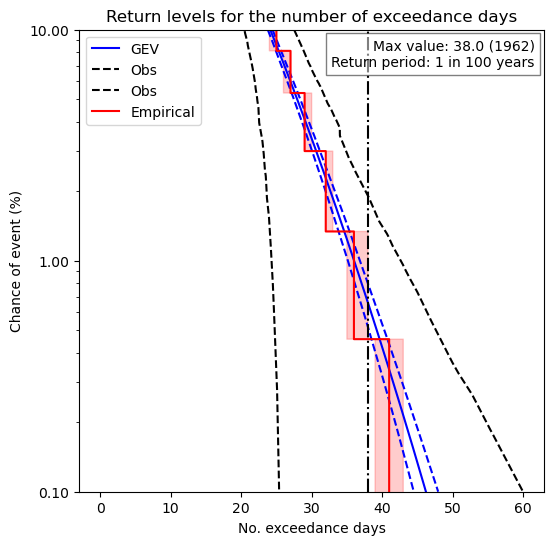

In [76]:
# Return periods relative to individual events
fig, ax = plt.subplots(figsize=(6, 6))

# plot the mean return levels
_ = plt.plot(
    levels_model_first,
    probs,
    "b-",
    label="GEV",
)

# Plot the range of return levels
_ = ax.plot(
    np.quantile(levels_model, [0.025, 0.975], axis=0).T, probs, "b--",
)

# plot the range of rweturn levels
_ = ax.plot(
    np.quantile(levels_obs, [0.025, 0.975], axis=0).T, probs, "k--", label="Obs"
)

# plot the return levels
_ = plt.plot(
    model_df_rl["sorted"],
    model_df_rl["probability"],
    color="red",
    label="Empirical",
)

# print the shape of model_rl
print(model_rl.shape)

# calculate the percentiles
model_vals_025 = np.percentile(model_rl, 2.5, axis=0)
model_vals_975 = np.percentile(model_rl, 97.5, axis=0)


# # plot the model vals 023
# _ = plt.plot(
#     model_vals_025,
#     model_df_rl["probability"],
#     color="blue",
# )

# fill between the percentiles
plt.fill_betweenx(
    model_df_rl["probability"],
    model_vals_025,
    model_vals_975,
    color="red",
    alpha=0.2,
)

# calculate and plot the mean
model_vals_mean = np.mean(model_rl, axis=0)

# plot the model data mean
# _ = plt.plot(
#     model_df_rl["sorted"],
#     model_vals_mean,
#     color="blue",
# )

# # Plot the model data
# _ = plt.fill_between(
#     model_df_rl["probability"],
#     model_vals_025,
#     model_vals_975,
#     color="red",
#     alpha=0.2,
# )

# plot a dot dahsed line for the worst value in the obs
plt.axvline(
    np.max(df_exceedance_days_obs["no_exceedance_days"]),
    color="black",
    linestyle="-.",
)

# Estimate the return period of this in years
return_period_val = funcs.estimate_period(
    return_level=np.max(df_exceedance_days_obs["no_exceedance_days"]),
    loc=model_params[0][1],
    scale=model_params[0][2],
    shape=model_params[0][0],
)

# find the year of the max value
max_year = df_exceedance_days_obs["no_exceedance_days"].idxmax()

# Include a textbox in the top right
plt.text(
    0.98,
    0.98,
    f"Max value: {np.max(round(df_exceedance_days_obs['no_exceedance_days']))} ({max_year})\nReturn period: 1 in {round(return_period_val)} years",
    horizontalalignment="right",
    verticalalignment="top",
    transform=ax.transAxes,
    fontsize=10,
    bbox=dict(facecolor="white", alpha=0.5),
)

# # # aesthetics
ax.set_ylim(0, 20)  # Adjust as needed

# # horizontal line at 1
# plt.axhline(1, color="black", linestyle="--")

# set the xpoints
x_points = np.array([20, 10, 5, 2, 1, 0.5, 0.2, 0.1])

# set the xlim
# ax.set_xlim(10, -20)

ax.set_yscale("log")
# set the yticks
# ax.set_yticks(x_points)

# set ylim
ax.set_ylim(0.1, 10)

ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_ylabel("Chance of event (%)")
# ax.set_xlabel(f"Lower than {obs_time_lowest} ({units})")

# Set the xlabel
ax.set_xlabel(f"No. exceedance days")

# include a legend in the top left
plt.legend(loc="upper left")

# set up the title
plt.title("Return levels for the number of exceedance days")

In [77]:
# Same but for the severity index
import matplotlib
import warnings
from scipy.stats import genextreme as gev

# silence the warnings
warnings.filterwarnings("ignore")

# Set up the probabilities
probs = 1 / np.arange(1.1, 1000, 0.1) * 100

years = np.arange(1.1, 1000, 0.1)

# assuming ONDJFM
# set up the lead years
lead_years = np.arange(1, 11)

# set up the months
months = [10, 11, 12, 1, 2, 3]

# Set up the number of samples
n_samples = 1000

# Quantify the return levels
# For the number of exceedance days
model_df_rl = funcs.empirical_return_level(
    data=df_model_exceedance["severity"].values,
    high_values_rare=True,
)

# print the head of the model_df_rl
print(model_df_rl.head())

# reverse the order of the rows
model_df_rl_inverse = model_df_rl.iloc[::-1]

# print the head of the model_df_rl_inverse
print(model_df_rl_inverse.head())

# Create an array to store the return levels
model_rl = np.zeros([n_samples, len(model_df_rl)])
obs_rl = np.zeros([n_samples, len(df_exceedance_days_obs)])

# Set up the model params
model_params = []
obs_params = []
model_params_first = []

model_params_first.append(
    gev.fit(
        df_model_exceedance["severity"],
    )
)

# Loop over the no. samples
for i in tqdm(range(n_samples)):
    # Sample the model data
    model_vals_this = np.random.choice(
        df_model_exceedance["severity"],
        size=len(model_df_rl["sorted"]),
        replace=True,
    )

    # set up the obs vals this
    obs_vals_this = np.random.choice(
        df_exceedance_days_obs["severity"],
        size=len(df_exceedance_days_obs["severity"]),
        replace=True,
    )

    # Quantify the empirical return levels
    model_df_rl_this = funcs.empirical_return_level(
        data=model_vals_this,
        high_values_rare=True,
    )

    # Quantify the return levels using the gev
    model_params.append(
        gev.fit(
            model_vals_this,
        )
    )

    # Set up the obs return levels
    obs_params.append(
        gev.fit(
            obs_vals_this,
        )
    )

    # Store the model return levels
    model_rl[i, :] = model_df_rl_this["sorted"]


levels_model = []
levels_obs = []

# loop over the num_samples
for i in range(n_samples):
    # Generate the ppf fit
    levels_model.append(
        np.array(gev.ppf(
            1 - 1 / years,
            *model_params[i],
        ))
    )

    # Generate the ppf fit
    levels_obs.append(
        np.array(gev.ppf(
            1 - 1 / years,
            *obs_params[i],
        ))
    )

# # Generate the ppf fit
levels_model_first = np.array(gev.ppf(
    1 - 1 / years,
    *model_params_first[0],
))

      sorted  rank_sp  exceedance    period  probability
5899     0.0   5900.0    0.999831  1.000169    99.983054
5898     0.0   5899.0    0.999661  1.000339    99.966107
5897     0.0   5898.0    0.999492  1.000509    99.949161
5896     0.0   5897.0    0.999322  1.000678    99.932215
5895     0.0   5896.0    0.999153  1.000848    99.915269
       sorted  rank_sp  exceedance       period  probability
0  154.530085      5.5    0.000932  1072.909091     0.093205
1  149.671527      5.5    0.000932  1072.909091     0.093205
2  143.881254      5.5    0.000932  1072.909091     0.093205
3  143.854365      5.5    0.000932  1072.909091     0.093205
4  142.734678      5.5    0.000932  1072.909091     0.093205


  0%|          | 3/1000 [00:00<02:31,  6.60it/s]

100%|██████████| 1000/1000 [02:29<00:00,  6.68it/s]


(1000, 5900)


Text(0.5, 1.0, 'Return levels for the severity index')

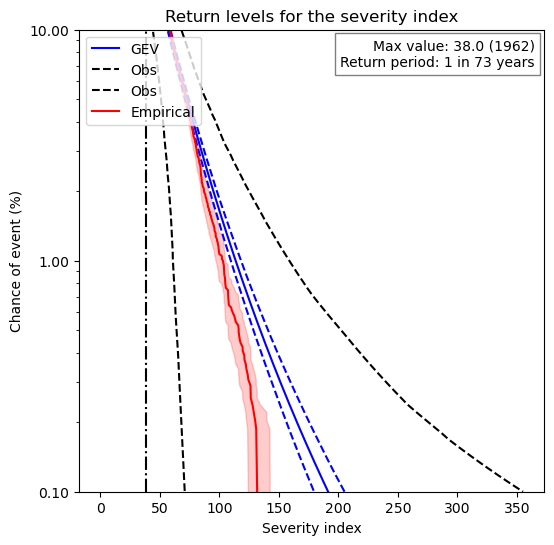

In [78]:
# Return periods relative to individual events
fig, ax = plt.subplots(figsize=(6, 6))

# plot the mean return levels
_ = plt.plot(
    levels_model_first,
    probs,
    "b-",
    label="GEV",
)

# Plot the range of return levels
_ = ax.plot(
    np.quantile(levels_model, [0.025, 0.975], axis=0).T, probs, "b--",
)

# plot the range of rweturn levels
_ = ax.plot(
    np.quantile(levels_obs, [0.025, 0.975], axis=0).T, probs, "k--", label="Obs"
)

# plot the return levels
_ = plt.plot(
    model_df_rl["sorted"],
    model_df_rl["probability"],
    color="red",
    label="Empirical",
)

# print the shape of model_rl
print(model_rl.shape)

# calculate the percentiles
model_vals_025 = np.percentile(model_rl, 2.5, axis=0)
model_vals_975 = np.percentile(model_rl, 97.5, axis=0)


# # plot the model vals 023
# _ = plt.plot(
#     model_vals_025,
#     model_df_rl["probability"],
#     color="blue",
# )

# fill between the percentiles
plt.fill_betweenx(
    model_df_rl["probability"],
    model_vals_025,
    model_vals_975,
    color="red",
    alpha=0.2,
)

# calculate and plot the mean
model_vals_mean = np.mean(model_rl, axis=0)

# plot the model data mean
# _ = plt.plot(
#     model_df_rl["sorted"],
#     model_vals_mean,
#     color="blue",
# )

# # Plot the model data
# _ = plt.fill_between(
#     model_df_rl["probability"],
#     model_vals_025,
#     model_vals_975,
#     color="red",
#     alpha=0.2,
# )

# plot a dot dahsed line for the worst value in the obs
plt.axvline(
    np.max(df_exceedance_days_obs["no_exceedance_days"]),
    color="black",
    linestyle="-.",
)

# Estimate the return period of this in years
return_period_val = funcs.estimate_period(
    return_level=np.max(df_exceedance_days_obs["no_exceedance_days"]),
    loc=model_params[0][1],
    scale=model_params[0][2],
    shape=model_params[0][0],
)

# find the year of the max value
max_year = df_exceedance_days_obs["no_exceedance_days"].idxmax()

# Include a textbox in the top right
plt.text(
    0.98,
    0.98,
    f"Max value: {np.max(round(df_exceedance_days_obs['no_exceedance_days']))} ({max_year})\nReturn period: 1 in {round(return_period_val)} years",
    horizontalalignment="right",
    verticalalignment="top",
    transform=ax.transAxes,
    fontsize=10,
    bbox=dict(facecolor="white", alpha=0.5),
)

# # # aesthetics
ax.set_ylim(0, 20)  # Adjust as needed

# # horizontal line at 1
# plt.axhline(1, color="black", linestyle="--")

# set the xpoints
x_points = np.array([20, 10, 5, 2, 1, 0.5, 0.2, 0.1])

# set the xlim
# ax.set_xlim(10, -20)

ax.set_yscale("log")
# set the yticks
# ax.set_yticks(x_points)

# set ylim
ax.set_ylim(0.1, 10)

ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_ylabel("Chance of event (%)")
# ax.set_xlabel(f"Lower than {obs_time_lowest} ({units})")

# Set the xlabel
ax.set_xlabel(f"Severity index")

# include a legend in the top left
plt.legend(loc="upper left")

# set up the title
plt.title("Return levels for the severity index")

In [79]:
# Same but for the winter_mean_dnw index
import matplotlib
import warnings
from scipy.stats import genextreme as gev

# silence the warnings
warnings.filterwarnings("ignore")

# Set up the probabilities
probs = 1 / np.arange(1.1, 1000, 0.1) * 100

years = np.arange(1.1, 1000, 0.1)

# assuming ONDJFM
# set up the lead years
lead_years = np.arange(1, 11)

# set up the months
months = [10, 11, 12, 1, 2, 3]

# Set up the number of samples
n_samples = 1000

# Quantify the return levels
# For the number of exceedance days
model_df_rl = funcs.empirical_return_level(
    data=df_model_exceedance["winter_mean_dnw"].values,
    high_values_rare=True,
)

# print the head of the model_df_rl
print(model_df_rl.head())

# reverse the order of the rows
model_df_rl_inverse = model_df_rl.iloc[::-1]

# print the head of the model_df_rl_inverse
print(model_df_rl_inverse.head())

# Create an array to store the return levels
model_rl = np.zeros([n_samples, len(model_df_rl)])
obs_rl = np.zeros([n_samples, len(df_exceedance_days_obs)])

# Set up the model params
model_params = []
obs_params = []
model_params_first = []

model_params_first.append(
    gev.fit(
        df_model_exceedance["winter_mean_dnw"],
    )
)

# Loop over the no. samples
for i in tqdm(range(n_samples)):
    # Sample the model data
    model_vals_this = np.random.choice(
        df_model_exceedance["winter_mean_dnw"],
        size=len(model_df_rl["sorted"]),
        replace=True,
    )

    # set up the obs vals this
    obs_vals_this = np.random.choice(
        df_exceedance_days_obs["winter_mean_dnw"],
        size=len(df_exceedance_days_obs["winter_mean_dnw"]),
        replace=True,
    )

    # Quantify the empirical return levels
    model_df_rl_this = funcs.empirical_return_level(
        data=model_vals_this,
        high_values_rare=True,
    )

    # Quantify the return levels using the gev
    model_params.append(
        gev.fit(
            model_vals_this,
        )
    )

    # Set up the obs return levels
    obs_params.append(
        gev.fit(
            obs_vals_this,
        )
    )

    # Store the model return levels
    model_rl[i, :] = model_df_rl_this["sorted"]


levels_model = []
levels_obs = []

# loop over the num_samples
for i in range(n_samples):
    # Generate the ppf fit
    levels_model.append(
        np.array(gev.ppf(
            1 - 1 / years,
            *model_params[i],
        ))
    )

    # Generate the ppf fit
    levels_obs.append(
        np.array(gev.ppf(
            1 - 1 / years,
            *obs_params[i],
        ))
    )

# # Generate the ppf fit
levels_model_first = np.array(gev.ppf(
    1 - 1 / years,
    *model_params_first[0],
))

         sorted  rank_sp  exceedance    period  probability
5899  22.022757   5900.0    0.999831  1.000169    99.983054
5898  22.741954   5899.0    0.999661  1.000339    99.966107
5897  23.025364   5898.0    0.999492  1.000509    99.949161
5896  23.328754   5897.0    0.999322  1.000678    99.932215
5895  23.386021   5896.0    0.999153  1.000848    99.915269
      sorted  rank_sp  exceedance   period  probability
0  33.852292      1.0    0.000169  5901.00     0.016946
1  33.781028      2.0    0.000339  2950.50     0.033893
2  33.716146      3.0    0.000508  1967.00     0.050839
3  33.481536      4.0    0.000678  1475.25     0.067785
4  33.471446      5.0    0.000847  1180.20     0.084731


  1%|          | 7/1000 [00:00<01:50,  9.01it/s]

100%|██████████| 1000/1000 [01:55<00:00,  8.68it/s]


(1000, 5900)


Text(0.5, 1.0, 'Return levels for the mean DnW')

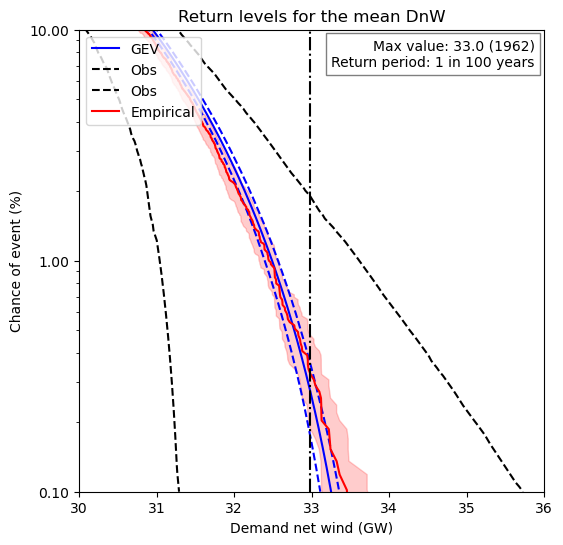

In [80]:
# Return periods relative to individual events
fig, ax = plt.subplots(figsize=(6, 6))

# plot the mean return levels
_ = plt.plot(
    levels_model_first,
    probs,
    "b-",
    label="GEV",
)

# Plot the range of return levels
_ = ax.plot(
    np.quantile(levels_model, [0.025, 0.975], axis=0).T, probs, "b--",
)

# plot the range of rweturn levels
_ = ax.plot(
    np.quantile(levels_obs, [0.025, 0.975], axis=0).T, probs, "k--", label="Obs"
)

# plot the return levels
_ = plt.plot(
    model_df_rl["sorted"],
    model_df_rl["probability"],
    color="red",
    label="Empirical",
)

# print the shape of model_rl
print(model_rl.shape)

# calculate the percentiles
model_vals_025 = np.percentile(model_rl, 2.5, axis=0)
model_vals_975 = np.percentile(model_rl, 97.5, axis=0)


# # plot the model vals 023
# _ = plt.plot(
#     model_vals_025,
#     model_df_rl["probability"],
#     color="blue",
# )

# fill between the percentiles
plt.fill_betweenx(
    model_df_rl["probability"],
    model_vals_025,
    model_vals_975,
    color="red",
    alpha=0.2,
)

# calculate and plot the mean
model_vals_mean = np.mean(model_rl, axis=0)

# plot the model data mean
# _ = plt.plot(
#     model_df_rl["sorted"],
#     model_vals_mean,
#     color="blue",
# )

# # Plot the model data
# _ = plt.fill_between(
#     model_df_rl["probability"],
#     model_vals_025,
#     model_vals_975,
#     color="red",
#     alpha=0.2,
# )

# plot a dot dahsed line for the worst value in the obs
plt.axvline(
    np.max(df_exceedance_days_obs["winter_mean_dnw"]),
    color="black",
    linestyle="-.",
)

# Estimate the return period of this in years
return_period_val = funcs.estimate_period(
    return_level=np.max(df_exceedance_days_obs["winter_mean_dnw"]),
    loc=model_params[0][1],
    scale=model_params[0][2],
    shape=model_params[0][0],
)

# find the year of the max value
max_year = df_exceedance_days_obs["winter_mean_dnw"].idxmax()

# Include a textbox in the top right
plt.text(
    0.98,
    0.98,
    f"Max value: {np.max(round(df_exceedance_days_obs['winter_mean_dnw']))} ({max_year})\nReturn period: 1 in {round(return_period_val)} years",
    horizontalalignment="right",
    verticalalignment="top",
    transform=ax.transAxes,
    fontsize=10,
    bbox=dict(facecolor="white", alpha=0.5),
)

# # # aesthetics
ax.set_ylim(0, 20)  # Adjust as needed

# # horizontal line at 1
# plt.axhline(1, color="black", linestyle="--")

# set the xpoints
x_points = np.array([20, 10, 5, 2, 1, 0.5, 0.2, 0.1])

# set the xlim
ax.set_xlim(30, 36)

ax.set_yscale("log")
# set the yticks
# ax.set_yticks(x_points)

# set ylim
ax.set_ylim(0.1, 10)

ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_ylabel("Chance of event (%)")
# ax.set_xlabel(f"Lower than {obs_time_lowest} ({units})")

# Set the xlabel
ax.set_xlabel(f"Demand net wind (GW)")

# include a legend in the top left
plt.legend(loc="upper left")

# set up the title
plt.title("Return levels for the mean DnW")

### EVA over time ###

Looking at the change in likelihood of demand net wind extremes over time

In [81]:
# reset the infex
df_exceedance_days_obs.reset_index(inplace=True)

In [82]:
df_exceedance_days_obs.head()

,index,severity,no_exceedance_days,winter_mean_dnw
0,1960,35.786467,18.0,29.328790
1,1961,73.972244,34.0,29.978915
2,1962,130.330120,38.0,32.978647
3,1963,31.710833,20.0,30.731293
4,1964,37.343381,21.0,31.321400


In [83]:
importlib.reload(funcs)

<module 'functions' from '/home/users/benhutch/unseen_functions/functions.py'>

In [84]:
# %%time

# funcs.plot_chance_of_event_with_time(
#     obs_df=df_exceedance_days_obs,
#     model_df=df_model_exceedance,
#     obs_val_name="no_exceedance_days",
#     model_val_name="no_exceedance_days",
#     obs_time_name="index",
#     variable="No. exceedance days",
#     lowest=False,
#     num_samples=100,
#     fname_prefix="no_exceedance_days_uk_dnw_1960-2018",
#     save_dir="/home/users/benhutch/unseen_multi_year/plots",
# )

In [85]:
df_model_exceedance.head()

,init_year,member,winter_year,severity,severity_05,severity_95,no_exceedance_days,no_exceedance_days_05,no_exceedance_days_95,winter_mean_dnw,winter_mean_dnw_05,winter_mean_dnw_95,effective_dec_year
0,1960,1,1,42.273743,2.501882,175.069957,19.0,3.0,48.0,29.752530,25.810431,33.698621,1961
0,1960,1,2,61.316058,4.747265,192.635859,22.0,4.0,49.0,30.682361,26.727583,34.610158,1962
0,1960,1,3,15.983207,0.000000,115.985512,11.0,0.0,43.0,30.098230,26.147786,34.045530,1963
0,1960,1,4,28.605026,1.017450,130.325786,14.0,2.0,40.0,28.622459,24.666145,32.576270,1964
0,1960,1,5,23.879285,0.667158,120.972749,11.0,1.0,41.0,27.897092,23.966694,31.867353,1965


In [87]:
df_model_exceedance["effective_dec_year"].unique()

array([1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971,
       1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982,
       1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
       1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
       2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026,
       2027, 2028])

In [98]:
num_samples=100

In [99]:
%%time

decades = np.arange(1960, 2030, 10)

decade_years = []

# Set up the decade years
for i, decade in enumerate(decades):
    if i == 0:
        decade_years.append(np.arange(decade, decade + 11))
    else:
        decade_years.append(np.arange(decade + 1, decade + 11))

# Flatten the list of arrays into a single list
flattened_years = np.concatenate(decade_years)

# Filter out the years not in df_model_exceedance["effective_dec_year"].unique()
filtered_years = [year for year in flattened_years if year in df_model_exceedance["effective_dec_year"].unique()]

# Reshape the filtered list back into the original decade structure
filtered_decade_years = []
for i, decade in enumerate(decades):
    if i == 0:
        filtered_decade_years.append(np.array([year for year in filtered_years if 1960 <= year <= 1970]))
    else:
        filtered_decade_years.append(np.array([year for year in filtered_years if decade + 1 <= year <= decade + 10]))

# Print filtered decade years
print(filtered_decade_years)

# try the same but with the empirical return levels
# extract the unique winter years from the model df
unique_winter_years = df_model_exceedance["effective_dec_year"].unique()

# find the year of the highest value for no exceedance days
# in the observed data
max_year = df_exceedance_days_obs["index"].iloc[
    df_exceedance_days_obs["no_exceedance_days"].idxmax()
]

# Print the max year
print("The year with the greatest no. exceedance days is: ", max_year)
print("The value is: ", df_exceedance_days_obs["no_exceedance_days"].max())

# set up params year
decade_params = np.zeros([len(filtered_decade_years), num_samples, 3])

# Loop over the unique winter years
for i, decade in tqdm(enumerate(filtered_decade_years)):
    # Subset the model data to the decade years
    df_model_exceedance_this = df_model_exceedance[
        df_model_exceedance["effective_dec_year"].isin(decade)
    ]

    # initialise the list of params
    params_decade = np.zeros([num_samples, 3])

    # Loop over the samples
    for j in range(num_samples):
        params_decade[j, :] = gev.fit(
            np.random.choice(
                df_model_exceedance_this["no_exceedance_days"],
                size=len(df_model_exceedance_this),
                replace=True,
            )
        )

    # append the params to the model year
    decade_params[i, :, :] = params_decade

[array([1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970]), array([1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980]), array([1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990]), array([1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000]), array([2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010]), array([2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]), array([2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028])]
The year with the greatest no. exceedance days is:  1962
The value is:  38.0


7it [00:37,  5.38s/it]

CPU times: user 37.5 s, sys: 2.54 ms, total: 37.5 s
Wall time: 37.7 s


In [100]:
np.shape(decade_params)

(7, 100, 3)

In [112]:
importlib.reload(funcs)

<module 'functions' from '/home/users/benhutch/unseen_functions/functions.py'>

In [119]:
# Set up the array for mean, 2.5th and 97.5th percentiles
period_decade_mean = np.zeros([len(filtered_decade_years)])
period_decade_025 = np.zeros([len(filtered_decade_years)])
period_decade_975 = np.zeros([len(filtered_decade_years)])

# find the value for the observed worst event
obs_worst_event = df_exceedance_days_obs["no_exceedance_days"].max()

# loop over the unique years to fit the ppfs
for i, decade in tqdm(enumerate(filtered_decade_years)):
    # Subset the params for the decade
    params_decade = decade_params[i, :, :]

    # Estimate the period for the model mean data
    period_decade_mean[i] = funcs.estimate_period(
        return_level=obs_worst_event,
        loc=np.mean(params_decade[:, 1]),
        scale=np.mean(params_decade[:, 2]),
        shape=np.mean(params_decade[:, 0]),
    )

    # model 025 percentile
    period_decade_025[i] = funcs.estimate_period(
        return_level=obs_worst_event,
        loc=np.percentile(params_decade[:, 1], 2.5),
        scale=np.percentile(params_decade[:, 2], 2.5),
        shape=np.percentile(params_decade[:, 0], 2.5),
    )

    # model 95 percentile
    period_decade_975[i] = funcs.estimate_period(
        return_level=obs_worst_event,
        loc=np.percentile(params_decade[:, 1], 97.5),
        scale=np.percentile(params_decade[:, 2], 97.5),
        shape=np.percentile(params_decade[:, 0], 97.5),
    )

# put these into a dataframe with the years
model_df_rl = pd.DataFrame(
    {
        "decade": decades,
        "mean": period_decade_mean,
        "025": period_decade_025,
        "975": period_decade_975,
    }
)

7it [00:00, 1333.64it/s]


In [120]:
model_df_rl.head()

,decade,mean,025,975
0,1960,99.013428,98.874677,99.077846
1,1970,99.046936,98.886974,99.148644
2,1980,99.303924,99.127873,99.446522
3,1990,99.317996,99.187571,99.452741
4,2000,99.608002,99.516992,99.705759


In [123]:
# for each row of "mean", "025", "975" calculate the return period
# 1 / (1 - (100 - value))
model_df_rl["mean_rp (%)"] = 1 - (model_df_rl["mean"] / 100)
model_df_rl["025_rp (%)"] = 1 - (model_df_rl["025"] / 100)
model_df_rl["975_rp (%)"] = 1 - (model_df_rl["975"] / 100)

In [124]:
model_df_rl.head()

,decade,mean,025,975,mean_rp (%),025_rp (%),975_rp (%)
0,1960,99.013428,98.874677,99.077846,0.009866,0.011253,0.009222
1,1970,99.046936,98.886974,99.148644,0.009531,0.011130,0.008514
2,1980,99.303924,99.127873,99.446522,0.006961,0.008721,0.005535
3,1990,99.317996,99.187571,99.452741,0.006820,0.008124,0.005473
4,2000,99.608002,99.516992,99.705759,0.003920,0.004830,0.002942


In [125]:
# calculate the return period in years of the observed worst event
model_df_rl["mean_rp (years)"] = 1 / model_df_rl["mean_rp (%)"]
model_df_rl["025_rp (years)"] = 1 / model_df_rl["025_rp (%)"]
model_df_rl["975_rp (years)"] = 1 / model_df_rl["975_rp (%)"]

In [142]:
model_df_rl

,decade,mean,025,975,mean_rp (%),025_rp (%),975_rp (%),mean_rp (years),025_rp (years),975_rp (years)
0,1960,99.013428,98.874677,99.077846,0.009866,0.011253,0.009222,101.361110,88.863340,108.441731
1,1970,99.046936,98.886974,99.148644,0.009531,0.011130,0.008514,104.924722,89.845194,117.459630
2,1980,99.303924,99.127873,99.446522,0.006961,0.008721,0.005535,143.662551,114.662144,180.675744
3,1990,99.317996,99.187571,99.452741,0.006820,0.008124,0.005473,146.626730,123.087633,182.728691
4,2000,99.608002,99.516992,99.705759,0.003920,0.004830,0.002942,255.103037,207.036083,339.857953
5,2010,99.698821,99.606728,99.798387,0.003012,0.003933,0.002016,332.028081,254.276753,496.000192
6,2020,99.955643,99.881159,99.987526,0.000444,0.001188,0.000125,2254.451621,841.463781,8016.515247


The year with the greatest no. exceedance days is:  1962


Text(0.5, 1.0, 'Return period of the worst no. exceedance days event (38, 1962)')

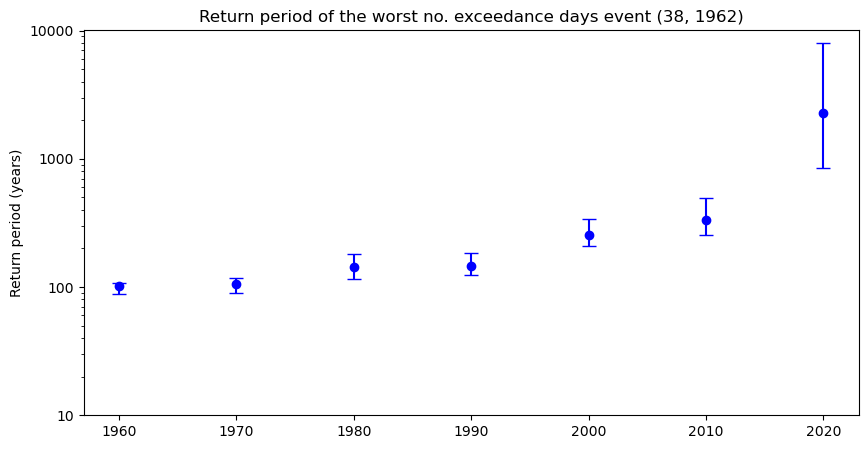

In [144]:
# plot the mean rp values with error bars for the 025 and 975 percentiles
plt.figure(figsize=(10, 5))

# plot the mean
plt.scatter(
    model_df_rl["decade"],
    model_df_rl["mean_rp (years)"],
    color="blue",
    label="Mean",
)

# plot the 025 and 975 percentiles
plt.errorbar(
    model_df_rl["decade"],
    model_df_rl["mean_rp (years)"],
    yerr=[
        model_df_rl["mean_rp (years)"] - model_df_rl["025_rp (years)"], # lower errors
        model_df_rl["975_rp (years)"] - model_df_rl["mean_rp (years)"], # upper errors
    ],
    fmt="none",
    ecolor="blue",
    capsize=5,
)

# set up a log yscale
plt.yscale("log")

# Set up the y ticks
plt.yticks([10, 100, 1000, 10000], ["10", "100", "1000", "10000"])

# set up the y axis labels
plt.ylabel("Return period (years)")

# find the year of the highest value for no exceedance days
# in the observed data
max_year = df_exceedance_days_obs["index"].iloc[
    df_exceedance_days_obs["no_exceedance_days"].idxmax()
]

# print max year
print("The year with the greatest no. exceedance days is: ", max_year)

# # set up the title
# Set up the title
plt.title(
    f"Return period of the worst no. exceedance days event ({round(df_exceedance_days_obs['no_exceedance_days'].max())}, {max_year})"
)

Text(0.5, 1.0, 'Return period of the worst no. exceedance days event (38, 1962)')

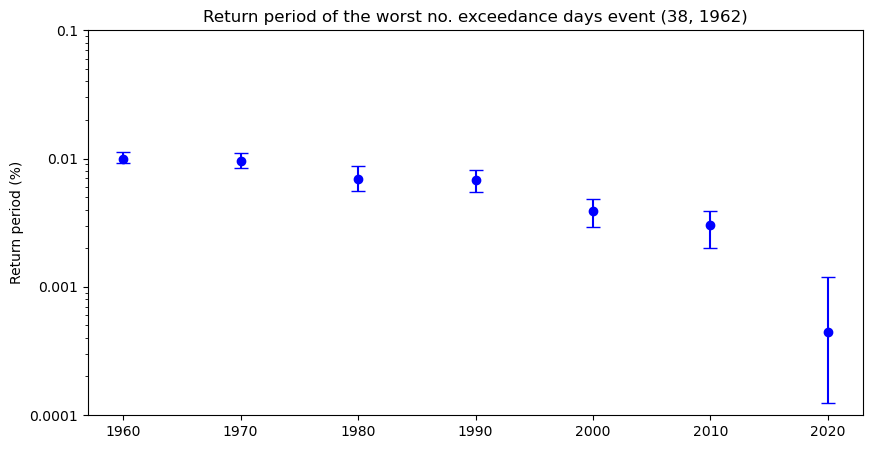

In [146]:
# Set up the figure
plt.figure(figsize=(10, 5))

# plot scatter of decade vs mean return period (%)
plt.scatter(
    model_df_rl["decade"],
    model_df_rl["mean_rp (%)"],
    color="blue",
    label="Mean",
)

# plot the 025 and 975 percentiles
plt.errorbar(
    model_df_rl["decade"],
    model_df_rl["mean_rp (%)"],
    yerr=[
        model_df_rl["mean_rp (%)"] - model_df_rl["975_rp (%)"], # lower errors
        model_df_rl["025_rp (%)"] - model_df_rl["mean_rp (%)"], # upper errors
    ],
    fmt="none",
    ecolor="blue",
    capsize=5,
)

# set up the yscale
plt.yscale("log")

# set up the yticks
plt.yticks([0.0001, 0.001, 0.01, 0.1], ["0.0001", "0.001", "0.01", "0.1"])

# set up the ylabel
plt.ylabel("Return period (%)")

# set up the title
plt.title(
    f"Return period of the worst no. exceedance days event ({round(df_exceedance_days_obs['no_exceedance_days'].max())}, {max_year})"
)

Same but for the severity index and mean demand net wind now

In [147]:
%%time

# try the same but with the empirical return levels
# extract the unique winter years from the model df
unique_winter_years = df_model_exceedance["effective_dec_year"].unique()

# find the year of the highest value for no exceedance days
# in the observed data
max_year = df_exceedance_days_obs["index"].iloc[
    df_exceedance_days_obs["severity"].idxmax()
]

# Print the max year
print("The year with the greatest no. exceedance days is: ", max_year)
print("The value is: ", df_exceedance_days_obs["severity"].max())

# set up params year
decade_params = np.zeros([len(filtered_decade_years), num_samples, 3])

# Loop over the unique winter years
for i, decade in tqdm(enumerate(filtered_decade_years)):
    # Subset the model data to the decade years
    df_model_exceedance_this = df_model_exceedance[
        df_model_exceedance["effective_dec_year"].isin(decade)
    ]

    # initialise the list of params
    params_decade = np.zeros([num_samples, 3])

    # Loop over the samples
    for j in range(num_samples):
        params_decade[j, :] = gev.fit(
            np.random.choice(
                df_model_exceedance_this["severity"],
                size=len(df_model_exceedance_this),
                replace=True,
            )
        )

    # append the params to the model year
    decade_params[i, :, :] = params_decade

The year with the greatest no. exceedance days is:  1962
The value is:  130.3301203272764


7it [00:34,  4.98s/it]

CPU times: user 34.6 s, sys: 0 ns, total: 34.6 s
Wall time: 34.8 s


In [148]:
# Set up the array for mean, 2.5th and 97.5th percentiles
period_decade_mean = np.zeros([len(filtered_decade_years)])
period_decade_025 = np.zeros([len(filtered_decade_years)])
period_decade_975 = np.zeros([len(filtered_decade_years)])

# find the value for the observed worst event
obs_worst_event = df_exceedance_days_obs["severity"].max()

# loop over the unique years to fit the ppfs
for i, decade in tqdm(enumerate(filtered_decade_years)):
    # Subset the params for the decade
    params_decade = decade_params[i, :, :]

    # Estimate the period for the model mean data
    period_decade_mean[i] = funcs.estimate_period(
        return_level=obs_worst_event,
        loc=np.mean(params_decade[:, 1]),
        scale=np.mean(params_decade[:, 2]),
        shape=np.mean(params_decade[:, 0]),
    )

    # model 025 percentile
    period_decade_025[i] = funcs.estimate_period(
        return_level=obs_worst_event,
        loc=np.percentile(params_decade[:, 1], 2.5),
        scale=np.percentile(params_decade[:, 2], 2.5),
        shape=np.percentile(params_decade[:, 0], 2.5),
    )

    # model 95 percentile
    period_decade_975[i] = funcs.estimate_period(
        return_level=obs_worst_event,
        loc=np.percentile(params_decade[:, 1], 97.5),
        scale=np.percentile(params_decade[:, 2], 97.5),
        shape=np.percentile(params_decade[:, 0], 97.5),
    )

# put these into a dataframe with the years
model_df_rl = pd.DataFrame(
    {
        "decade": decades,
        "mean": period_decade_mean,
        "025": period_decade_025,
        "975": period_decade_975,
    }
)

7it [00:00, 1314.95it/s]


In [150]:
# for each row of "mean", "025", "975" calculate the return period
# 1 / (1 - (100 - value))
model_df_rl["mean_rp (%)"] = 1 - (model_df_rl["mean"] / 100)
model_df_rl["025_rp (%)"] = 1 - (model_df_rl["025"] / 100)
model_df_rl["975_rp (%)"] = 1 - (model_df_rl["975"] / 100)

# calculate the return period in years of the observed worst event
model_df_rl["mean_rp (years)"] = 1 / model_df_rl["mean_rp (%)"]
model_df_rl["025_rp (years)"] = 1 / model_df_rl["025_rp (%)"]
model_df_rl["975_rp (years)"] = 1 / model_df_rl["975_rp (%)"]

The year with the greatest severity index is:  1962


Text(0.5, 1.0, 'Return period of the worst no. exceedance days event (130, 1962)')

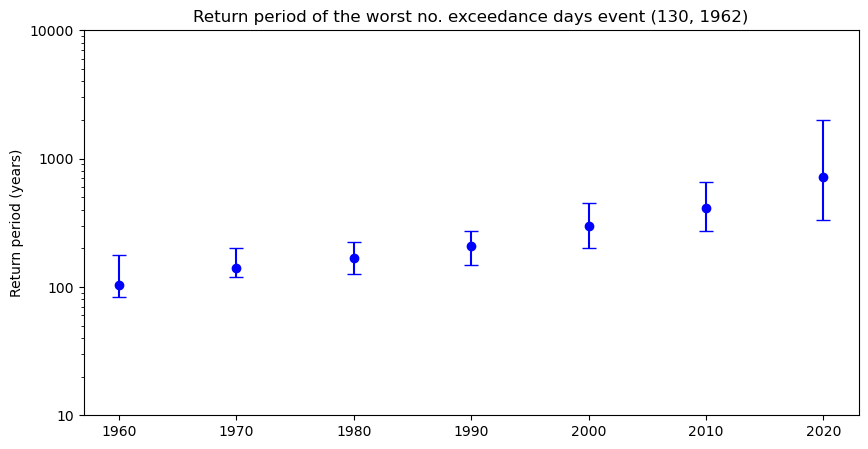

In [151]:
# plot the mean rp values with error bars for the 025 and 975 percentiles
plt.figure(figsize=(10, 5))

# plot the mean
plt.scatter(
    model_df_rl["decade"],
    model_df_rl["mean_rp (years)"],
    color="blue",
    label="Mean",
)

# plot the 025 and 975 percentiles
plt.errorbar(
    model_df_rl["decade"],
    model_df_rl["mean_rp (years)"],
    yerr=[
        model_df_rl["mean_rp (years)"] - model_df_rl["025_rp (years)"], # lower errors
        model_df_rl["975_rp (years)"] - model_df_rl["mean_rp (years)"], # upper errors
    ],
    fmt="none",
    ecolor="blue",
    capsize=5,
)

# set up a log yscale
plt.yscale("log")

# Set up the y ticks
plt.yticks([10, 100, 1000, 10000], ["10", "100", "1000", "10000"])

# set up the y axis labels
plt.ylabel("Return period (years)")

# find the year of the highest value for no exceedance days
# in the observed data
max_year = df_exceedance_days_obs["index"].iloc[
    df_exceedance_days_obs["severity"].idxmax()
]

# print max year
print("The year with the greatest severity index is: ", max_year)

# # set up the title
# Set up the title
plt.title(
    f"Return period of the worst no. exceedance days event ({round(df_exceedance_days_obs['severity'].max())}, {max_year})"
)

Text(0.5, 1.0, 'Return period of the worst severity event (130, 1962)')

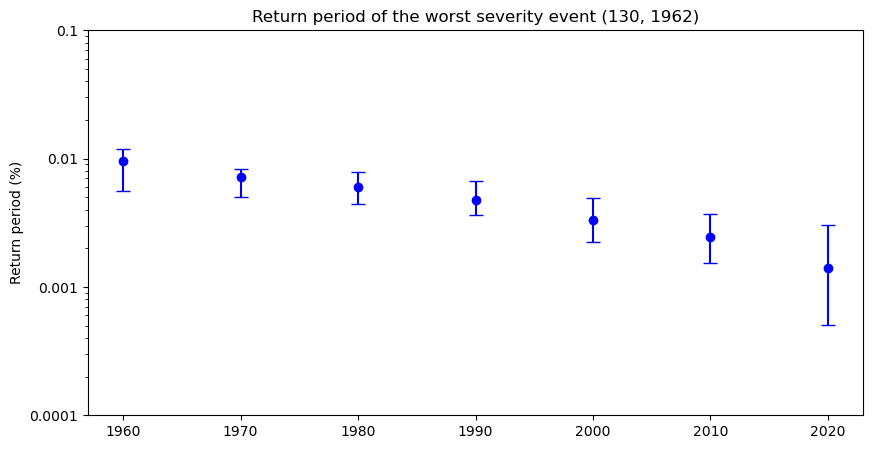

In [152]:
# Set up the figure
plt.figure(figsize=(10, 5))

# plot scatter of decade vs mean return period (%)
plt.scatter(
    model_df_rl["decade"],
    model_df_rl["mean_rp (%)"],
    color="blue",
    label="Mean",
)

# plot the 025 and 975 percentiles
plt.errorbar(
    model_df_rl["decade"],
    model_df_rl["mean_rp (%)"],
    yerr=[
        model_df_rl["mean_rp (%)"] - model_df_rl["975_rp (%)"], # lower errors
        model_df_rl["025_rp (%)"] - model_df_rl["mean_rp (%)"], # upper errors
    ],
    fmt="none",
    ecolor="blue",
    capsize=5,
)

# set up the yscale
plt.yscale("log")

# set up the yticks
plt.yticks([0.0001, 0.001, 0.01, 0.1], ["0.0001", "0.001", "0.01", "0.1"])

# set up the ylabel
plt.ylabel("Return period (%)")

# set up the title
plt.title(
    f"Return period of the worst severity event ({round(df_exceedance_days_obs['severity'].max())}, {max_year})"
)

In [153]:
df_exceedance_days_obs.head()

,index,severity,no_exceedance_days,winter_mean_dnw
0,1960,35.786467,18.0,29.328790
1,1961,73.972244,34.0,29.978915
2,1962,130.330120,38.0,32.978647
3,1963,31.710833,20.0,30.731293
4,1964,37.343381,21.0,31.321400


In [162]:
%%time

# try the same but with the empirical return levels
# extract the unique winter years from the model df
unique_winter_years = df_model_exceedance["effective_dec_year"].unique()

# find the year of the highest value for no exceedance days
# in the observed data
max_year = df_exceedance_days_obs["index"].iloc[
    df_exceedance_days_obs["winter_mean_dnw"].idxmax()
]

# Print the max year
print("The year with the greatest no. exceedance days is: ", max_year)
print("The value is: ", df_exceedance_days_obs["winter_mean_dnw"].max())

# set up params year
decade_params = np.zeros([len(filtered_decade_years), num_samples, 3])

# Loop over the unique winter years
for i, decade in tqdm(enumerate(filtered_decade_years)):
    # Subset the model data to the decade years
    df_model_exceedance_this = df_model_exceedance[
        df_model_exceedance["effective_dec_year"].isin(decade)
    ]

    # initialise the list of params
    params_decade = np.zeros([num_samples, 3])

    # Loop over the samples
    for j in range(num_samples):
        params_decade[j, :] = gev.fit(
            np.random.choice(
                df_model_exceedance_this["winter_mean_dnw"],
                size=len(df_model_exceedance_this),
                replace=True,
            )
        )

    # append the params to the model year
    decade_params[i, :, :] = params_decade

The year with the greatest no. exceedance days is:  1962
The value is:  32.97864706864766


7it [00:21,  3.03s/it]

CPU times: user 21.1 s, sys: 1.79 ms, total: 21.1 s
Wall time: 21.2 s


In [163]:
# Set up the array for mean, 2.5th and 97.5th percentiles
period_decade_mean = np.zeros([len(filtered_decade_years)])
period_decade_025 = np.zeros([len(filtered_decade_years)])
period_decade_975 = np.zeros([len(filtered_decade_years)])

# find the value for the observed worst event
obs_worst_event = df_exceedance_days_obs["winter_mean_dnw"].max()

# loop over the unique years to fit the ppfs
for i, decade in tqdm(enumerate(filtered_decade_years)):
    # Subset the params for the decade
    params_decade = decade_params[i, :, :]

    # Estimate the period for the model mean data
    period_decade_mean[i] = funcs.estimate_period(
        return_level=obs_worst_event,
        loc=np.mean(params_decade[:, 1]),
        scale=np.mean(params_decade[:, 2]),
        shape=np.mean(params_decade[:, 0]),
    )

    # model 025 percentile
    period_decade_025[i] = funcs.estimate_period(
        return_level=obs_worst_event,
        loc=np.percentile(params_decade[:, 1], 2.5),
        scale=np.percentile(params_decade[:, 2], 2.5),
        shape=np.percentile(params_decade[:, 0], 2.5),
    )

    # model 95 percentile
    period_decade_975[i] = funcs.estimate_period(
        return_level=obs_worst_event,
        loc=np.percentile(params_decade[:, 1], 97.5),
        scale=np.percentile(params_decade[:, 2], 97.5),
        shape=np.percentile(params_decade[:, 0], 97.5),
    )

# put these into a dataframe with the years
model_df_rl = pd.DataFrame(
    {
        "decade": decades,
        "mean": period_decade_mean,
        "025": period_decade_025,
        "975": period_decade_975,
    }
)

7it [00:00, 1362.36it/s]


In [164]:
# for each row of "mean", "025", "975" calculate the return period
# 1 / (1 - (100 - value))
model_df_rl["mean_rp (%)"] = 1 - (model_df_rl["mean"] / 100)
model_df_rl["025_rp (%)"] = 1 - (model_df_rl["025"] / 100)
model_df_rl["975_rp (%)"] = 1 - (model_df_rl["975"] / 100)

# calculate the return period in years of the observed worst event
model_df_rl["mean_rp (years)"] = 1 / model_df_rl["mean_rp (%)"]
model_df_rl["025_rp (years)"] = 1 / model_df_rl["025_rp (%)"]
model_df_rl["975_rp (years)"] = 1 / model_df_rl["975_rp (%)"]

In [165]:
model_df_rl.tail()

,decade,mean,025,975,mean_rp (%),025_rp (%),975_rp (%),mean_rp (years),025_rp (years),975_rp (years)
2,1980,99.783610,99.847725,99.882297,0.002164,0.001523,0.001177,462.128330,656.704640,849.596079
3,1990,99.700447,99.783800,99.708853,0.002996,0.002162,0.002911,333.830489,462.535437,343.469287
4,2000,99.862615,99.844740,99.942879,0.001374,0.001553,0.000571,727.882631,644.082929,1750.662093
5,2010,99.949129,99.957619,99.960122,0.000509,0.000424,0.000399,1965.758152,2359.562602,2507.654880
6,2020,100.000000,99.998399,100.000000,0.000000,0.000016,0.000000,inf,62464.728270,inf


The year with the greatest winter_mean_dnw is:  1962


Text(0.5, 1.0, 'Return period of the worst no. exceedance days event (33, 1962)')

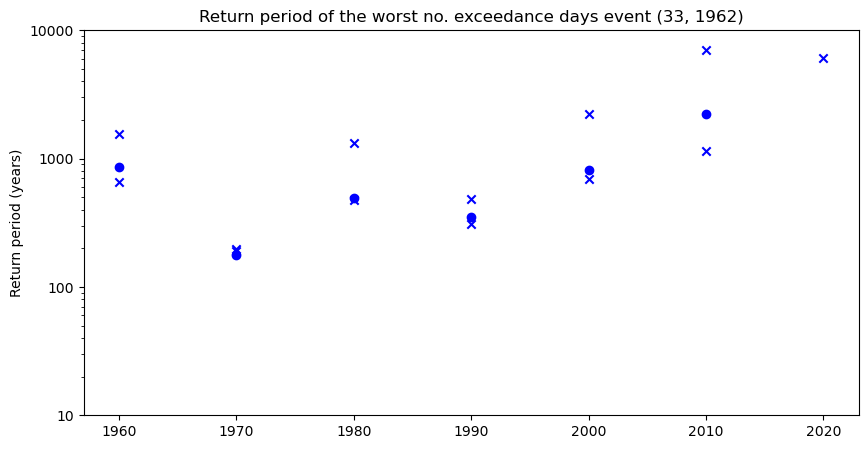

In [160]:
# plot the mean rp values with error bars for the 025 and 975 percentiles
plt.figure(figsize=(10, 5))

# plot the mean
plt.scatter(
    model_df_rl["decade"],
    model_df_rl["mean_rp (years)"],
    color="blue",
    label="Mean",
)

# plot the 025 scatter
plt.scatter(
    model_df_rl["decade"],
    model_df_rl["025_rp (years)"],
    color="blue",
    label="025",
    marker="x",
)

# plot the 975 scatter
plt.scatter(
    model_df_rl["decade"],
    model_df_rl["975_rp (years)"],
    color="blue",
    label="975",
    marker="x",
)

# set up a log yscale
plt.yscale("log")

# Set up the y ticks
plt.yticks([10, 100, 1000, 10000], ["10", "100", "1000", "10000"])

# set up the y axis labels
plt.ylabel("Return period (years)")

# find the year of the highest value for no exceedance days
# in the observed data
max_year = df_exceedance_days_obs["index"].iloc[
    df_exceedance_days_obs["winter_mean_dnw"].idxmax()
]

# print max year
print("The year with the greatest winter_mean_dnw is: ", max_year)

# # set up the title
# Set up the title
plt.title(
    f"Return period of the worst no. exceedance days event ({round(df_exceedance_days_obs['winter_mean_dnw'].max())}, {max_year})"
)

In [137]:
# plot the mean rp values with error bars for the 025 and 975 percentiles
plt.figure(figsize=(10, 5))

# plot the mean
plt.scatter(
    model_df_rl["decade"],
    model_df_rl["mean_rp (years)"],
    color="blue",
    label="Mean",
)

# plot the 025 and 975 percentiles
plt.errorbar(
    model_df_rl["decade"],
    model_df_rl["mean_rp (years)"],
    yerr=[
        model_df_rl["mean_rp (years)"] - model_df_rl["025_rp (years)"], # lower errors
        model_df_rl["975_rp (years)"] - model_df_rl["mean_rp (years)"], # upper errors
    ],
    fmt="none",
    ecolor="blue",
    capsize=5,
)

# set up a log yscale
plt.yscale("log")

# Set up the y ticks
plt.yticks([10, 100, 1000, 10000], ["10", "100", "1000", "10000"])

# set up the y axis labels
plt.ylabel("Return period (years)")

# find the year of the highest value for no exceedance days
# in the observed data
max_year = df_exceedance_days_obs["index"].iloc[
    df_exceedance_days_obs["no_exceedance_days"].idxmax()
]

# print max year
print("The year with the greatest no. exceedance days is: ", max_year)

# # set up the title
# Set up the title
plt.title(
    f"Return period of the worst no. exceedance days event ({round(df_exceedance_days_obs['no_exceedance_days'].max())}, {max_year})"
)

array([0.98698198, 0.98950007, 0.98996029, 0.99      , 0.98987959,
       0.9898437 , 0.99      , 0.98998305, 0.99      , 0.98984281,
       0.98994122, 0.9899328 , 0.98993004, 0.98997274, 0.98995783,
       0.98990883, 0.98985086, 0.9899107 , 0.98995633, 0.98987583,
       0.99      , 0.98989846, 0.98990849, 0.98994952, 0.98998095,
       0.98999991, 0.98996967, 0.98993296, 0.98990616, 0.98990949,
       0.98994671, 0.9899863 , 0.98989932, 0.98998189, 0.99      ,
       0.98986304, 0.98977387, 0.98993647, 0.98999217, 0.98995251,
       0.98997697, 0.98994094, 0.98991941, 0.98995037, 0.9899579 ,
       0.99      , 0.989974  , 0.98992794, 0.98995017, 0.98999998,
       0.98999367, 0.98997837, 0.99      , 0.98998352, 0.98990176,
       0.98994808, 0.98999914, 0.9899911 , 0.98996904, 0.98990836,
       0.99      , 0.98994199, 0.98999999, 0.99      , 0.98990999,
       0.98999887, 0.98981679, 0.99      ])

In [118]:
model_df_rl.head()

,year,mean,025,975,mean_8yr,025_8yr,975_8yr
13,1974,-36684.284192,-12836.683535,-165990.239910,-16327.209042,-8230.406736,-4.412287e+04
14,1975,-23710.889005,-8589.906323,-28316.414261,-16931.719061,-8409.874032,-1.037009e+06
15,1976,-10969.041577,-5176.192197,-14646.229202,-17667.484826,-8487.934295,-1.036231e+06
16,1977,-6705.106792,-3466.887165,-10094.710290,-16814.013470,-7477.669913,-1.035423e+06
39,2000,-21058.595605,-12270.223393,-130324.979141,-31134.614312,-11366.849335,-3.888640e+05


Text(0.5, 1.0, 'Chance of DnW event >1962')

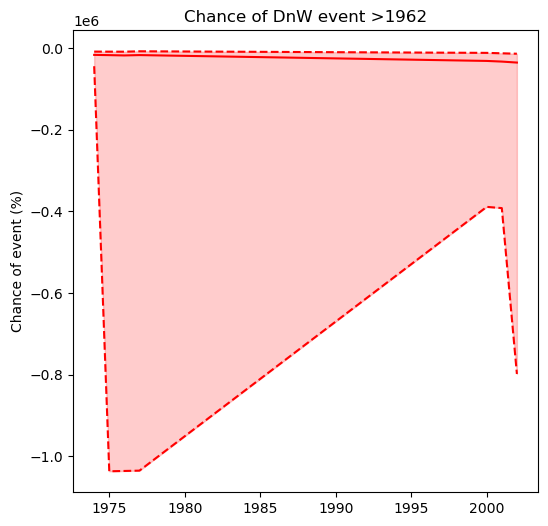

In [117]:
# take a centred 8-year running mean for mean 025 and 975
model_df_rl["mean_8yr"] = model_df_rl["mean"].rolling(window=8, center=True).mean()
model_df_rl["025_8yr"] = model_df_rl["025"].rolling(window=8, center=True).mean()
model_df_rl["975_8yr"] = model_df_rl["975"].rolling(window=8, center=True).mean()

# remove Nans from the dataframe
model_df_rl = model_df_rl.dropna()

# set up the figure
fig, ax = plt.subplots(figsize=(6, 6))

# plot the mean return level
ax.plot(
    model_df_rl["year"],
    model_df_rl["mean_8yr"],
    color="red",
    label="HadGEM3-GC31-MM",
)

# plot the 025 return level
ax.plot(
    model_df_rl["year"],
    model_df_rl["025_8yr"],
    color="red",
    linestyle="--",
)
ax.plot(
    model_df_rl["year"],
    model_df_rl["975_8yr"],
    color="red",
    linestyle="--",
)

# shadde between the 025 and 975 return levels
ax.fill_between(
    model_df_rl["year"],
    model_df_rl["025_8yr"],
    model_df_rl["975_8yr"],
    color="red",
    alpha=0.2,
)

# # set the x-axis label
# ax.set_xlabel("Year")

# set the y-axis label
ax.set_ylabel(f"Chance of event (%)")

# set the title
ax.set_title(f"Chance of DnW event >{max_year}")


In [5]:
def get_member_string(member, model):
    """
    Returns the appropriate member string based on the member value.
    
    Parameters:
    member (int): The member number (1 to 10).
    model (str): The model name.
    
    Returns:
    str: The corresponding member string.
    """
    # check the model is HadGEM3-GC31-MM
    if model != "HadGEM3-GC31-MM":
        raise ValueError("Model must be HadGEM3-GC31-MM")

    if 1 <= member <= 10 and model == "HadGEM3-GC31-MM":
        return f'r{member}i1p1f2'
    else:
        raise ValueError("Member must be between 1 and 10")

# Example usage
member = 3
member_string = get_member_string(member, model)
print(member_string)  # Output: r3i1p1f2

r3i1p1f2


In [6]:
# if country has a space, replace with _
country = country.replace(" ", "_")

# Set up the name for the df
df_name = f"{model}_{experiment}_{variable}_{country}_{init_year}_{member}_{freq}.csv"
df_name_next = f"{model}_{experiment}_{variable}_{country}_{init_year+1}_{member}_{freq}.csv"

In [7]:
# join the dfs
df = pd.read_csv(os.path.join(output_dir_dfs, df_name))
df_next = pd.read_csv(os.path.join(output_dir_dfs, df_name_next))

In [8]:
df.head()

,init_year,member,lead,data
0,1960,3,1,283.936085
1,1960,3,2,281.669556
2,1960,3,3,280.445822
3,1960,3,4,280.883473
4,1960,3,5,280.189686


In [9]:
df_next.head()

,init_year,member,lead,data
0,1961,3,1,283.591079
1,1961,3,2,282.982020
2,1961,3,3,278.014896
3,1961,3,4,277.302433
4,1961,3,5,282.388435


In [10]:
# join the dataframes
df = pd.concat([df, df_next])

In [11]:
df.tail()

,init_year,member,lead,data
3745,1961,3,3746,278.792032
3746,1961,3,3747,278.351358
3747,1961,3,3748,276.485531
3748,1961,3,3749,279.756007
3749,1961,3,3750,278.945528


In [53]:
# set up the variable
variable = "sfcWind"
country = "United_Kingdom"

In [54]:
# Set up the years
years = np.arange(init_year, 2018 + 1)

# Set up the members
members = np.arange(1, 10 + 1)

# Set up an empty df
df_all = pd.DataFrame()

# Loop over the years and members
for year in tqdm(years):
    for member in members:
        # Set up the name for the df
        df_name = f"{model}_{experiment}_{variable}_{country}_{year}_{member}_{freq}.csv"
        df = pd.read_csv(os.path.join(output_dir_dfs, df_name))
        df_all = pd.concat([df_all, df])

100%|██████████| 59/59 [00:45<00:00,  1.31it/s]


In [59]:
df_all.tail()

,init_year,member,lead,data
3745,2018,10,3746,7.075536
3746,2018,10,3747,3.919252
3747,2018,10,3748,3.330906
3748,2018,10,3749,5.101384
3749,2018,10,3750,5.210266


In [14]:
# drop the unnamed column
df_all = df_all.drop(columns="Unnamed: 0")

In [60]:
# reset the index
df_all_reset = df_all.reset_index(drop=True)

In [62]:
df_all_reset.tail()

,init_year,member,lead,data
2212505,2018,10,3746,7.075536
2212506,2018,10,3747,3.919252
2212507,2018,10,3748,3.330906
2212508,2018,10,3749,5.101384
2212509,2018,10,3750,5.210266


In [63]:
%%time

# Set up a name for the df all reset
df_name_all = f"{model}_{experiment}_{variable}_{country}_1960-2018_{freq}.csv"

# Save the df
df_all_reset.to_csv(os.path.join(output_dir_dfs, df_name_all), index=False)

CPU times: user 2.27 s, sys: 55.6 ms, total: 2.33 s
Wall time: 2.68 s


In [18]:
df_all_reset.head()

,init_year,member,lead,data
0,1960,1,1,283.904326
1,1960,1,2,281.653069
2,1960,1,3,280.558694
3,1960,1,4,280.931852
4,1960,1,5,280.171699


In [19]:
# Load and process the observed data to compare against
# Set up the path to the observed data
base_path = "/gws/nopw/j04/canari/users/benhutch/ERA5/"

test_file_path = "/badc/cmip6/data/CMIP6/DCPP/MOHC/HadGEM3-GC31-MM/dcppA-hindcast/s1961-r9i1p1f2/day/tas/gn/files/d20200417/tas_day_HadGEM3-GC31-MM_dcppA-hindcast_s1961-r9i1p1f2_gn_19720101-19720330.nc"

# if the variable is tas
if variable == "tas":
    obs_path = os.path.join(base_path, "ERA5_t2m_daily_1950_2020.nc")
elif variable == "sfcWind":
    obs_path = os.path.join(base_path, "ERA5_wind_daily_1960_2020.nc")
else:
    raise ValueError("Variable not recognised.")

# Assert that the obs path exists
assert os.path.exists(obs_path), "Observations path does not exist."

# set up the obs variab;e
if variable == "tas":
    obs_variable = "t2m"
elif variable == "sfcWind":
    obs_variable = "si10"
else:
    raise ValueError("Variable not recognised.")

# load the obs cube test
obs_cube_test = iris.load_cube(obs_path)

# load the model cube test (for regridding)
model_cube_test = iris.load_cube(test_file_path)

# constrain to the relevant years
obs_cube_test = obs_cube_test.extract(
    iris.Constraint(time=lambda cell: 1960 <= cell.point.year <= 2018)
)

# perform the intersection
obs_cube_test = obs_cube_test.intersection(
    latitude=(30, 80),
    longitude=(-40, 30),
)

# print the model cube test dimensions
print("Model cube test dimensions:")
print(model_cube_test)

# Select the first member and time from the model cube
model_cube_regrid = model_cube_test[0, :, :]

# print the model cube regrid dimensions
print("Model cube regrid dimensions:")
print(model_cube_regrid)

model_cube_regrid.coord("latitude").units = obs_cube_test[0].coord("latitude").units
model_cube_regrid.coord("longitude").units = obs_cube_test[0].coord("longitude").units

# and for the attributes
model_cube_regrid.coord("latitude").attributes = obs_cube_test[0].coord("latitude").attributes
model_cube_regrid.coord("longitude").attributes = obs_cube_test[0].coord("longitude").attributes

obs_cube_regrid = obs_cube_test.regrid(model_cube_regrid, iris.analysis.Linear())

Model cube test dimensions:
air_temperature / (K)               (time: 90; latitude: 324; longitude: 432)
    Dimension coordinates:
        time                             x             -               -
        latitude                         -             x               -
        longitude                        -             -               x
    Scalar coordinates:
        height                      1.5 m
    Cell methods:
        0                           area: time: mean
    Attributes:
        Conventions                 'CF-1.7 CMIP-6.2'
        activity_id                 'DCPP'
        branch_method               'no parent'
        branch_time_in_child        np.float64(0.0)
        branch_time_in_parent       np.float64(0.0)
        cmor_version                '3.4.0'
        comment                     'near-surface (usually, 2 meter) air temperature'
        creation_date               '2020-06-15T03:03:46Z'
        cv_version                  '6.2.37.5'
        da

/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/iris/fileformats/cf.py:880: IrisCfMissingVarWarning: Missing CF-netCDF measure variable 'areacella', referenced by netCDF variable 'tas'
  warnings.warn(


In [20]:
model_cube_test

<iris 'Cube' of air_temperature / (K) (time: 90; latitude: 324; longitude: 432)>

In [21]:
country

'United_Kingdom'

In [22]:
# create the mask
MASK_MATRIX = funcs.create_masked_matrix(
    country="United Kingdom",
    cube=model_cube_regrid,
)

Found Country United Kingdom


In [23]:
%%time

obs_data = obs_cube_regrid.data

In [ ]:
# Apply the mask to the observed and model data
obs_values = obs_data * MASK_MATRIX
# model_values = model_cube.data * MASK_MATRIX

# Where there are zeros we want to set these to NaNs
obs_values = np.where(obs_values == 0, np.nan, obs_values)
# model_values = np.where(model_values == 0, np.nan, model_values)

# Take the Nanmean of the data
# over lat and lon dims
obs_mean = np.nanmean(obs_values, axis=(1, 2))
# model_mean = np.nanmean(model_values, axis=(2, 3))

KeyboardInterrupt: 

In [ ]:
%%time

# Load the model data
model_ds = funcs.load_model_data_xarray(
    model_variable=variable,
    model=model,
    experiment=experiment,
    start_year=init_year,
    end_year=init_year,
    first_fcst_year=init_year + 1,
    last_fcst_year=init_year + 10,
    months=months,
    member="r1i1p1f2",
    frequency=freq,
    parallel=False,
)

Model path: /badc/cmip6/data/CMIP6/DCPP/MOHC/HadGEM3-GC31-MM/dcppA-hindcast


The model path root is badc
Number of unique variant labels: 10
For model: HadGEM3-GC31-MM
First 10 unique variant labels: ['r10i1p1f2' 'r1i1p1f2' 'r2i1p1f2' 'r3i1p1f2' 'r4i1p1f2' 'r5i1p1f2'
 'r6i1p1f2' 'r7i1p1f2' 'r8i1p1f2' 'r9i1p1f2']
Number of unique variant labels: 10
Unique variant labels: ['r10i1p1f2' 'r1i1p1f2' 'r2i1p1f2' 'r3i1p1f2' 'r4i1p1f2' 'r5i1p1f2'
 'r6i1p1f2' 'r7i1p1f2' 'r8i1p1f2' 'r9i1p1f2']
First 10 model files: ['/badc/cmip6/data/CMIP6/DCPP/MOHC/HadGEM3-GC31-MM/dcppA-hindcast/s1960-r10i1p1f2/day/tas/gn/files/d20200417/tas_day_HadGEM3-GC31-MM_dcppA-hindcast_s1960-r10i1p1f2_gn_19601101-19601230.nc', '/badc/cmip6/data/CMIP6/DCPP/MOHC/HadGEM3-GC31-MM/dcppA-hindcast/s1960-r10i1p1f2/day/tas/gn/files/d20200417/tas_day_HadGEM3-GC31-MM_dcppA-hindcast_s1960-r10i1p1f2_gn_19610101-19611230.nc', '/badc/cmip6/data/CMIP6/DCPP/MOHC/HadGEM3-GC31-MM/dcppA-hindcast/s1960-r10i1p1f2/day/tas/gn/files/d20200417/tas_day_HadGEM3-GC31-MM_dcppA-hindcast_s1960-r10i1p1f2_gn_19620101-19621230.nc', 

Processing init years: 100%|██████████| 1/1 [00:00<00:00,  2.38it/s]

CPU times: user 332 ms, sys: 78.1 ms, total: 410 ms
Wall time: 809 ms


In [ ]:
model_ds

<xarray.Dataset> Size: 2GB
Dimensions:    (init: 1, member: 1, lead: 3750, bnds: 2, lat: 324, lon: 432)
Coordinates:
  * lead       (lead) int64 30kB 1 2 3 4 5 6 7 ... 3745 3746 3747 3748 3749 3750
  * lat        (lat) float64 3kB -89.72 -89.17 -88.61 ... 88.61 89.17 89.72
  * lon        (lon) float64 3kB 0.4167 1.25 2.083 2.917 ... 357.9 358.7 359.6
    height     float64 8B ...
  * member     (member) <U8 32B 'r1i1p1f2'
  * init       (init) int64 8B 1960
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (init, member, lead, bnds) object 60kB dask.array<chunksize=(1, 1, 1, 2), meta=np.ndarray>
    lat_bnds   (init, member, lat, bnds) float64 5kB dask.array<chunksize=(1, 1, 324, 2), meta=np.ndarray>
    lon_bnds   (init, member, lon, bnds) float64 7kB dask.array<chunksize=(1, 1, 432, 2), meta=np.ndarray>
    tas        (init, member, lead, lat, lon) float32 2GB dask.array<chunksize=(1, 1, 1, 324, 432), meta=np.ndarray>
Attributes: (12/45)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            DCPP
    branch_method:          no parent
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    creation_date:          2020-05-27T13:57:33Z
    ...                     ...
    variable_name:          tas
    variant_label:          r1i1p1f2
    license:                CMIP6 model data produced by Met Office Hadley Ce...
    cmor_version:           3.4.0
    first_month:            1960-11-01 12:00:00
    time_axis_type:         Datetime360Day

In [ ]:
# convert modify the member coordinate
model_ds["member"] = model_ds["member"].str[1:-6].astype(int)

# convert to an iris cube
model_cube = model_ds[variable].squeeze().to_iris()

# Make sure cube is on the correct grid system
model_cube = model_cube.intersection(longitude=(-180, 180))

In [ ]:
# Create the mask matrix for the UK
MASK_MATRIX = funcs.create_masked_matrix(
    country=country,
    cube=model_cube,
)

Found Country United Kingdom


In [ ]:
%%time

model_data = model_cube.data

CPU times: user 25.9 s, sys: 4.07 s, total: 30 s
Wall time: 21.9 s


In [ ]:
%%time

# Apply the mask to the model cube
model_values = model_data * MASK_MATRIX

# Where there are zeros in the mask we want to set these to Nans
model_values_masked = np.where(MASK_MATRIX == 0, np.nan, model_values)

CPU times: user 1.66 s, sys: 1.25 s, total: 2.91 s
Wall time: 2.93 s


In [ ]:
%%time

# Take the Nanmean of the data
model_values = np.nanmean(model_values_masked, axis=(1, 2))

CPU times: user 3.4 s, sys: 817 ms, total: 4.22 s
Wall time: 4.24 s


In [ ]:
model_values_masked.shape

(3750, 324, 432)

In [ ]:
%%time

model_df = pd.DataFrame()

# Extract the ini years, member and lead times
init_years = model_cube.coord("init").points
members = model_cube.coord("member").points
lead_times = model_cube.coord("lead").points


# loop through the inits, members and leadtimes
for i, init_year in enumerate(init_years):
    for m, member in enumerate(members):
        for l, lead_time in enumerate(lead_times):
            # get the model data
            model_data = model_values[l]

            # set up the model df this
            model_df_this = pd.DataFrame(
                {
                    "init_year": [init_year],
                    "member": [member],
                    "lead": [lead_time],
                    "data": [model_data],
                },
            )

            # concat to the model df
            model_df = pd.concat([model_df, model_df_this])

CPU times: user 1.6 s, sys: 1.47 ms, total: 1.6 s
Wall time: 1.61 s


In [ ]:
model_df.tail()

,init_year,member,lead,data
0,1960,1,3746,270.007662
0,1960,1,3747,270.725837
0,1960,1,3748,271.052666
0,1960,1,3749,271.333062
0,1960,1,3750,271.023811


In [ ]:
# if country has a space, replace with _
country = country.replace(" ", "_")

# Set up the name for the df
df_name = f"{model}_{experiment}_{variable}_{country}_{init_year}_{member}_{freq}.csv"

In [ ]:
df_name

'HadGEM3-GC31-MM_dcppA-hindcast_tas_United_Kingdom_1960_1_day.csv'

In [ ]:
output_dir_dfs

'/gws/nopw/j04/canari/users/benhutch/unseen/saved_dfs'

In [ ]:
# Save the df
model_df.to_csv(os.path.join(output_dir_dfs, df_name))